In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

from sklearn.model_selection import train_test_split

import utils.data as data

In [2]:
import torch
import torchvision.transforms as transforms

print("GPU support availble:", torch.cuda.is_available())

GPU support availble: True


## I. Import dataset and general overview
The labels dataset `data_labels.csv` includes the **image path**, 15 one-hot-encoded **FACs** and **emotions** in three categories: `negative`, `positive` and `surprise`.

In [3]:
gk_df = pd.read_csv('data/data_labels.csv')

In [4]:
# examine the dataframe
gk_df.head()

,subject,sequence,image_index,filepath,file_prefix,AU17,AU1,AU2,AU25,AU27,...,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
0,S005,1,11,./cohn-kanade-images/S005/001/S005_001_0000001...,S005_001_00000011,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,S010,1,14,./cohn-kanade-images/S010/001/S010_001_0000001...,S010_001_00000014,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,negative
2,S010,2,14,./cohn-kanade-images/S010/002/S010_002_0000001...,S010_002_00000014,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,surprise
3,S010,3,18,./cohn-kanade-images/S010/003/S010_003_0000001...,S010_003_00000018,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,S010,4,19,./cohn-kanade-images/S010/004/S010_004_0000001...,S010_004_00000019,1,0,0,0,0,...,1,1,1,0,0,0,0,0,0,negative


In [5]:
gk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   subject             560 non-null    object
 1   sequence            560 non-null    int64 
 2   image_index         560 non-null    int64 
 3   filepath            560 non-null    object
 4   file_prefix         560 non-null    object
 5   AU17                560 non-null    int64 
 6   AU1                 560 non-null    int64 
 7   AU2                 560 non-null    int64 
 8   AU25                560 non-null    int64 
 9   AU27                560 non-null    int64 
 10  AU4                 560 non-null    int64 
 11  AU7                 560 non-null    int64 
 12  AU23                560 non-null    int64 
 13  AU24                560 non-null    int64 
 14  AU6                 560 non-null    int64 
 15  AU12                560 non-null    int64 
 16  AU15                560 no

In [6]:
# drop unnecessary columns
drop_columns = ['subject', 'sequence', 'image_index', 'file_prefix']

In [7]:
gk_df = gk_df.drop(columns=drop_columns)

In [8]:
gk_df.head()

,filepath,AU17,AU1,AU2,AU25,AU27,AU4,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
0,./cohn-kanade-images/S005/001/S005_001_0000001...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
1,./cohn-kanade-images/S010/001/S010_001_0000001...,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,negative
2,./cohn-kanade-images/S010/002/S010_002_0000001...,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,surprise
3,./cohn-kanade-images/S010/003/S010_003_0000001...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,negative
4,./cohn-kanade-images/S010/004/S010_004_0000001...,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,negative


#### Examine `high_level_emotion`

In [9]:
gk_df['high_level_emotion'].value_counts()

high_level_emotion
negative    328
positive    121
surprise    111
Name: count, dtype: int64

- The dataset is **imbalanced** as class `negative` accumulated the most.

## II. Data Analysis

In [10]:
FACs = gk_df.columns[1:-1]

In [11]:
FACs

Index(['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24',
       'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26'],
      dtype='object')

In [12]:
crosstab = pd.crosstab(gk_df['AU1'], gk_df['high_level_emotion'])

In [13]:
print(crosstab)

high_level_emotion  negative  positive  surprise
AU1                                             
0                        239       117        27
1                         89         4        84


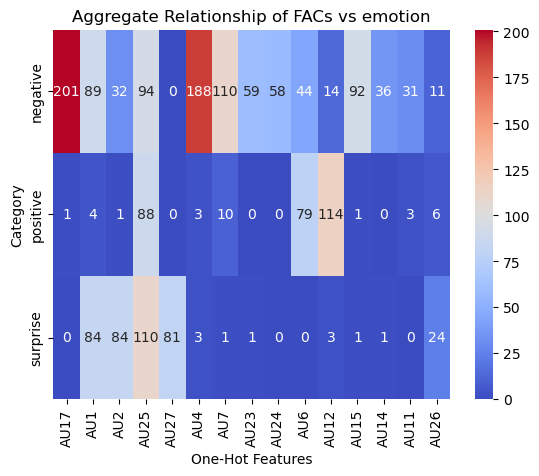

In [14]:
# Sum one-hot encoded features grouped by the categorical feature
grouped_sum = gk_df.groupby('high_level_emotion')[FACs].sum()

# Heatmap to visualize
sns.heatmap(grouped_sum, annot=True, fmt='.0f', cmap='coolwarm')
plt.title("Aggregate Relationship of FACs vs emotion")
plt.ylabel("Category")
plt.xlabel("One-Hot Features")
plt.show()


- The majority of the expression are related to `negative` emotion with **AU17**, **AU7**, **AU4** and **AU15** are the most signifcant indicators.
- **AU6** and **AU12**  play a significant role in the `positive` category.
- **AU1**, **AU2**, **AU25**, **AU27** are the expression that are more related to `surprise`.
- **AU25** is actually common for most of the emotions and slightly represents `surprise` more.
- Several features (like **AU14**, **AU11**, **AU26**) have consistently low counts across all categories => indicating they may not contribute much to distinguishing these categories.

=> *The analysis show that the expressions are strongly related to certain emotion and for that, the **features** we may extract from **CNN models** can be used to dictate both as in **recognizing the facial actions** and **classifying the emotion***

## III. Data Preparation

In [15]:
importlib.reload(data)

<module 'utils.data' from 'D:\\bin\\Facial-Emotion-Expression-Recognition\\utils\\data.py'>

In [16]:
# split the dataset
train_df, val_df = data.split_dataset('data/data_labels.csv', random_state=42)

##### Train Dataset and Loaders

In [17]:
train_dataset = data.EmotionFACsDataset(train_df)

In [18]:
train_loader = data.DataLoader(train_dataset, batch_size=32)

**Data Augmentated**

*Avoid overfitting during training due to the humble size of the train data*

In [19]:
aug_transform =transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

In [20]:
aug_train_dataset = data.EmotionFACsDataset(train_df, transform=aug_transform)

In [21]:
aug_train_loader = data.DataLoader(train_dataset, batch_size=32)

##### Val Dataset and Loaders
`Validate Dataset` is **not shuffled** in order to maintain the consistency upon validating the model 

In [22]:
val_dataset = data.EmotionFACsDataset(val_df)

In [23]:
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)

### IV. Modelling

In [24]:
import models.model as model
import utils.CNN_trainer as trainer

In [25]:
importlib.reload(model)

<module 'models.model' from 'D:\\bin\\Facial-Emotion-Expression-Recognition\\models\\model.py'>

In [26]:
importlib.reload(trainer)

<module 'utils.CNN_trainer' from 'D:\\bin\\Facial-Emotion-Expression-Recognition\\utils\\CNN_trainer.py'>

#### Resnet50

In [27]:
resnet50 = model.EmotionFACsNet()

In [28]:
resnet50_trainer= trainer.EmotionFACsTrainer(resnet50, 'resnet50', train_loader, val_loader)

In [29]:
resnet50_trainer.train(num_epochs = 100)


Epoch 1/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.32it/s]


Train - Emotion Loss: 0.9935, FACS Loss: 0.5627
Train - Emotion F1: 0.2934, FACS F1: 0.1699
Val - Emotion Loss: 0.9674, FACS Loss: 0.5270
Val - Emotion F1: 0.2472, FACS F1: 0.0062

Epoch 2/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.50it/s]


Train - Emotion Loss: 0.9666, FACS Loss: 0.5032
Train - Emotion F1: 0.2460, FACS F1: 0.1111
Val - Emotion Loss: 0.9579, FACS Loss: 0.4645
Val - Emotion F1: 0.2472, FACS F1: 0.0000

Epoch 3/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.9669, FACS Loss: 0.4976
Train - Emotion F1: 0.2460, FACS F1: 0.1019
Val - Emotion Loss: 0.9577, FACS Loss: 0.4593
Val - Emotion F1: 0.2472, FACS F1: 0.0000

Epoch 4/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.56it/s]


Train - Emotion Loss: 0.9668, FACS Loss: 0.4967
Train - Emotion F1: 0.2460, FACS F1: 0.1039
Val - Emotion Loss: 0.9578, FACS Loss: 0.4570
Val - Emotion F1: 0.2472, FACS F1: 0.0306

Epoch 5/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.51it/s]


Train - Emotion Loss: 0.9666, FACS Loss: 0.4900
Train - Emotion F1: 0.2460, FACS F1: 0.0836
Val - Emotion Loss: 0.9578, FACS Loss: 0.4551
Val - Emotion F1: 0.2472, FACS F1: 0.0330

Epoch 6/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.53it/s]


Train - Emotion Loss: 0.9665, FACS Loss: 0.4880
Train - Emotion F1: 0.2460, FACS F1: 0.0988
Val - Emotion Loss: 0.9578, FACS Loss: 0.4566
Val - Emotion F1: 0.2472, FACS F1: 0.0355

Epoch 7/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.9666, FACS Loss: 0.4871
Train - Emotion F1: 0.2460, FACS F1: 0.1061
Val - Emotion Loss: 0.9578, FACS Loss: 0.4548
Val - Emotion F1: 0.2472, FACS F1: 0.0424

Epoch 8/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.9667, FACS Loss: 0.4859
Train - Emotion F1: 0.2460, FACS F1: 0.0866
Val - Emotion Loss: 0.9578, FACS Loss: 0.4540
Val - Emotion F1: 0.2472, FACS F1: 0.0414

Epoch 9/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.9667, FACS Loss: 0.4838
Train - Emotion F1: 0.2460, FACS F1: 0.0893
Val - Emotion Loss: 0.9577, FACS Loss: 0.4527
Val - Emotion F1: 0.2472, FACS F1: 0.0497

Epoch 10/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.9665, FACS Loss: 0.4777
Train - Emotion F1: 0.2460, FACS F1: 0.0991
Val - Emotion Loss: 0.9577, FACS Loss: 0.4492
Val - Emotion F1: 0.2472, FACS F1: 0.0568

Epoch 11/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.9666, FACS Loss: 0.4736
Train - Emotion F1: 0.2460, FACS F1: 0.1190
Val - Emotion Loss: 0.9577, FACS Loss: 0.4457
Val - Emotion F1: 0.2472, FACS F1: 0.0557

Epoch 12/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.9665, FACS Loss: 0.4809
Train - Emotion F1: 0.2460, FACS F1: 0.1031
Val - Emotion Loss: 0.9578, FACS Loss: 0.4525
Val - Emotion F1: 0.2472, FACS F1: 0.0464

Epoch 13/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.9664, FACS Loss: 0.4732
Train - Emotion F1: 0.2460, FACS F1: 0.1243
Val - Emotion Loss: 0.9578, FACS Loss: 0.4503
Val - Emotion F1: 0.2472, FACS F1: 0.0551

Epoch 14/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.9662, FACS Loss: 0.4698
Train - Emotion F1: 0.2460, FACS F1: 0.1224
Val - Emotion Loss: 0.9578, FACS Loss: 0.4524
Val - Emotion F1: 0.2472, FACS F1: 0.0531

Epoch 15/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.9666, FACS Loss: 0.4666
Train - Emotion F1: 0.2460, FACS F1: 0.1496
Val - Emotion Loss: 0.9580, FACS Loss: 0.5068
Val - Emotion F1: 0.2472, FACS F1: 0.0493

Epoch 16/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.9663, FACS Loss: 0.4676
Train - Emotion F1: 0.2460, FACS F1: 0.1375
Val - Emotion Loss: 0.9578, FACS Loss: 0.4687
Val - Emotion F1: 0.2472, FACS F1: 0.1230

Epoch 17/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.55it/s]


Train - Emotion Loss: 0.9658, FACS Loss: 0.4602
Train - Emotion F1: 0.2460, FACS F1: 0.1461
Val - Emotion Loss: 0.9581, FACS Loss: 0.4604
Val - Emotion F1: 0.2472, FACS F1: 0.1023

Epoch 18/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.9629, FACS Loss: 0.4573
Train - Emotion F1: 0.2460, FACS F1: 0.1671
Val - Emotion Loss: 0.9587, FACS Loss: 0.5320
Val - Emotion F1: 0.2472, FACS F1: 0.1113

Epoch 19/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.9612, FACS Loss: 0.4503
Train - Emotion F1: 0.2598, FACS F1: 0.1731
Val - Emotion Loss: 0.9961, FACS Loss: 0.4923
Val - Emotion F1: 0.3367, FACS F1: 0.1099

Epoch 20/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.9439, FACS Loss: 0.4548
Train - Emotion F1: 0.2806, FACS F1: 0.1530
Val - Emotion Loss: 0.9900, FACS Loss: 0.4661
Val - Emotion F1: 0.2844, FACS F1: 0.0941

Epoch 21/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.9387, FACS Loss: 0.4593
Train - Emotion F1: 0.3266, FACS F1: 0.1532
Val - Emotion Loss: 1.0092, FACS Loss: 0.4755
Val - Emotion F1: 0.3331, FACS F1: 0.0864

Epoch 22/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.9201, FACS Loss: 0.4547
Train - Emotion F1: 0.3715, FACS F1: 0.1621
Val - Emotion Loss: 1.0079, FACS Loss: 0.4551
Val - Emotion F1: 0.2723, FACS F1: 0.1444

Epoch 23/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.9156, FACS Loss: 0.4561
Train - Emotion F1: 0.3949, FACS F1: 0.1760
Val - Emotion Loss: 0.9948, FACS Loss: 0.4632
Val - Emotion F1: 0.3258, FACS F1: 0.0727

Epoch 24/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.9093, FACS Loss: 0.4601
Train - Emotion F1: 0.3782, FACS F1: 0.1492
Val - Emotion Loss: 0.9579, FACS Loss: 0.4513
Val - Emotion F1: 0.3595, FACS F1: 0.1202

Epoch 25/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.8867, FACS Loss: 0.4402
Train - Emotion F1: 0.4426, FACS F1: 0.1862
Val - Emotion Loss: 1.0333, FACS Loss: 0.4808
Val - Emotion F1: 0.3381, FACS F1: 0.0951

Epoch 26/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.8642, FACS Loss: 0.4431
Train - Emotion F1: 0.4691, FACS F1: 0.1824
Val - Emotion Loss: 0.9972, FACS Loss: 0.4587
Val - Emotion F1: 0.2905, FACS F1: 0.1207

Epoch 27/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.8276, FACS Loss: 0.4347
Train - Emotion F1: 0.5200, FACS F1: 0.2022
Val - Emotion Loss: 0.9782, FACS Loss: 0.4552
Val - Emotion F1: 0.3120, FACS F1: 0.1125

Epoch 28/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.8309, FACS Loss: 0.4317
Train - Emotion F1: 0.5176, FACS F1: 0.2060
Val - Emotion Loss: 1.0002, FACS Loss: 0.4693
Val - Emotion F1: 0.2990, FACS F1: 0.0966

Epoch 29/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.54it/s]


Train - Emotion Loss: 0.8639, FACS Loss: 0.4378
Train - Emotion F1: 0.5042, FACS F1: 0.2149
Val - Emotion Loss: 0.9907, FACS Loss: 0.4615
Val - Emotion F1: 0.3676, FACS F1: 0.0935

Epoch 30/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.52it/s]


Train - Emotion Loss: 0.8497, FACS Loss: 0.4291
Train - Emotion F1: 0.4758, FACS F1: 0.2170
Val - Emotion Loss: 0.9998, FACS Loss: 0.4606
Val - Emotion F1: 0.2603, FACS F1: 0.1080

Epoch 31/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.8522, FACS Loss: 0.4343
Train - Emotion F1: 0.4922, FACS F1: 0.1956
Val - Emotion Loss: 1.0621, FACS Loss: 0.4789
Val - Emotion F1: 0.2642, FACS F1: 0.1188

Epoch 32/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.55it/s]


Train - Emotion Loss: 0.8274, FACS Loss: 0.4239
Train - Emotion F1: 0.5340, FACS F1: 0.2136
Val - Emotion Loss: 0.9663, FACS Loss: 0.4755
Val - Emotion F1: 0.3650, FACS F1: 0.1170

Epoch 33/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.7992, FACS Loss: 0.4173
Train - Emotion F1: 0.5707, FACS F1: 0.2344
Val - Emotion Loss: 1.0111, FACS Loss: 0.4664
Val - Emotion F1: 0.3365, FACS F1: 0.1425

Epoch 34/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.7765, FACS Loss: 0.4092
Train - Emotion F1: 0.6456, FACS F1: 0.2454
Val - Emotion Loss: 1.0175, FACS Loss: 0.4680
Val - Emotion F1: 0.3629, FACS F1: 0.1312

Epoch 35/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.7752, FACS Loss: 0.4029
Train - Emotion F1: 0.6523, FACS F1: 0.2657
Val - Emotion Loss: 1.0174, FACS Loss: 0.4687
Val - Emotion F1: 0.3673, FACS F1: 0.1232

Epoch 36/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.7576, FACS Loss: 0.3957
Train - Emotion F1: 0.6730, FACS F1: 0.2927
Val - Emotion Loss: 0.9934, FACS Loss: 0.4697
Val - Emotion F1: 0.3764, FACS F1: 0.0987

Epoch 37/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.7377, FACS Loss: 0.3926
Train - Emotion F1: 0.7505, FACS F1: 0.2770
Val - Emotion Loss: 1.0153, FACS Loss: 0.4728
Val - Emotion F1: 0.3238, FACS F1: 0.1305

Epoch 38/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.7155, FACS Loss: 0.3866
Train - Emotion F1: 0.7601, FACS F1: 0.3117
Val - Emotion Loss: 1.0283, FACS Loss: 0.4934
Val - Emotion F1: 0.4358, FACS F1: 0.1410

Epoch 39/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.7260, FACS Loss: 0.3788
Train - Emotion F1: 0.7442, FACS F1: 0.3275
Val - Emotion Loss: 1.0735, FACS Loss: 0.4989
Val - Emotion F1: 0.3958, FACS F1: 0.1459

Epoch 40/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.6781, FACS Loss: 0.3673
Train - Emotion F1: 0.8544, FACS F1: 0.3601
Val - Emotion Loss: 1.0076, FACS Loss: 0.5159
Val - Emotion F1: 0.3868, FACS F1: 0.1583

Epoch 41/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.6924, FACS Loss: 0.3798
Train - Emotion F1: 0.8159, FACS F1: 0.3661
Val - Emotion Loss: 0.9487, FACS Loss: 0.4494
Val - Emotion F1: 0.4437, FACS F1: 0.2003

Epoch 42/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.6377, FACS Loss: 0.3531
Train - Emotion F1: 0.8904, FACS F1: 0.3770
Val - Emotion Loss: 1.0120, FACS Loss: 0.4448
Val - Emotion F1: 0.3826, FACS F1: 0.1849

Epoch 43/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.6287, FACS Loss: 0.3456
Train - Emotion F1: 0.9032, FACS F1: 0.3837
Val - Emotion Loss: 0.9399, FACS Loss: 0.4572
Val - Emotion F1: 0.5418, FACS F1: 0.2323

Epoch 44/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.6435, FACS Loss: 0.3479
Train - Emotion F1: 0.8644, FACS F1: 0.4162
Val - Emotion Loss: 0.9880, FACS Loss: 0.4646
Val - Emotion F1: 0.3564, FACS F1: 0.2132

Epoch 45/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.6636, FACS Loss: 0.3481
Train - Emotion F1: 0.8391, FACS F1: 0.4170
Val - Emotion Loss: 0.9565, FACS Loss: 0.5016
Val - Emotion F1: 0.4147, FACS F1: 0.1686

Epoch 46/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.6205, FACS Loss: 0.3365
Train - Emotion F1: 0.9134, FACS F1: 0.4383
Val - Emotion Loss: 1.0142, FACS Loss: 0.4578
Val - Emotion F1: 0.3821, FACS F1: 0.1611

Epoch 47/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.6149, FACS Loss: 0.3360
Train - Emotion F1: 0.9299, FACS F1: 0.4365
Val - Emotion Loss: 0.9776, FACS Loss: 0.4780
Val - Emotion F1: 0.4837, FACS F1: 0.2064

Epoch 48/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.6127, FACS Loss: 0.3337
Train - Emotion F1: 0.9209, FACS F1: 0.4395
Val - Emotion Loss: 1.0328, FACS Loss: 0.6653
Val - Emotion F1: 0.4167, FACS F1: 0.1730

Epoch 49/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.6122, FACS Loss: 0.3307
Train - Emotion F1: 0.9289, FACS F1: 0.4580
Val - Emotion Loss: 0.9726, FACS Loss: 0.5022
Val - Emotion F1: 0.3968, FACS F1: 0.1764

Epoch 50/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.6280, FACS Loss: 0.3325
Train - Emotion F1: 0.9093, FACS F1: 0.4279
Val - Emotion Loss: 0.9427, FACS Loss: 0.4830
Val - Emotion F1: 0.5113, FACS F1: 0.2340

Epoch 51/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.6133, FACS Loss: 0.3286
Train - Emotion F1: 0.9269, FACS F1: 0.4367
Val - Emotion Loss: 0.9450, FACS Loss: 0.4984
Val - Emotion F1: 0.4271, FACS F1: 0.1705

Epoch 52/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.6009, FACS Loss: 0.3130
Train - Emotion F1: 0.9447, FACS F1: 0.4714
Val - Emotion Loss: 0.9487, FACS Loss: 0.4465
Val - Emotion F1: 0.4273, FACS F1: 0.2075

Epoch 53/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5811, FACS Loss: 0.3124
Train - Emotion F1: 0.9720, FACS F1: 0.4707
Val - Emotion Loss: 0.8921, FACS Loss: 0.4460
Val - Emotion F1: 0.5189, FACS F1: 0.2247

Epoch 54/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5673, FACS Loss: 0.3007
Train - Emotion F1: 0.9867, FACS F1: 0.4820
Val - Emotion Loss: 0.9060, FACS Loss: 0.4473
Val - Emotion F1: 0.5098, FACS F1: 0.2312

Epoch 55/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5808, FACS Loss: 0.3016
Train - Emotion F1: 0.9659, FACS F1: 0.4964
Val - Emotion Loss: 0.8732, FACS Loss: 0.4370
Val - Emotion F1: 0.5269, FACS F1: 0.2233

Epoch 56/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5709, FACS Loss: 0.2933
Train - Emotion F1: 0.9793, FACS F1: 0.5056
Val - Emotion Loss: 0.8702, FACS Loss: 0.4491
Val - Emotion F1: 0.5835, FACS F1: 0.2636

Epoch 57/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5855, FACS Loss: 0.2888
Train - Emotion F1: 0.9646, FACS F1: 0.4907
Val - Emotion Loss: 0.9274, FACS Loss: 0.4520
Val - Emotion F1: 0.5063, FACS F1: 0.2623

Epoch 58/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5823, FACS Loss: 0.2914
Train - Emotion F1: 0.9688, FACS F1: 0.5156
Val - Emotion Loss: 0.9120, FACS Loss: 0.4591
Val - Emotion F1: 0.5147, FACS F1: 0.2252

Epoch 59/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5760, FACS Loss: 0.2821
Train - Emotion F1: 0.9732, FACS F1: 0.5290
Val - Emotion Loss: 0.8899, FACS Loss: 0.4635
Val - Emotion F1: 0.5434, FACS F1: 0.2680

Epoch 60/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.52it/s]


Train - Emotion Loss: 0.5838, FACS Loss: 0.2806
Train - Emotion F1: 0.9624, FACS F1: 0.5146
Val - Emotion Loss: 0.8620, FACS Loss: 0.4685
Val - Emotion F1: 0.6071, FACS F1: 0.2940

Epoch 61/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5793, FACS Loss: 0.2810
Train - Emotion F1: 0.9670, FACS F1: 0.5303
Val - Emotion Loss: 0.8865, FACS Loss: 0.4813
Val - Emotion F1: 0.5600, FACS F1: 0.2622

Epoch 62/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5888, FACS Loss: 0.2909
Train - Emotion F1: 0.9488, FACS F1: 0.5057
Val - Emotion Loss: 0.8930, FACS Loss: 0.4575
Val - Emotion F1: 0.5909, FACS F1: 0.2673

Epoch 63/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5851, FACS Loss: 0.2871
Train - Emotion F1: 0.9590, FACS F1: 0.5200
Val - Emotion Loss: 0.9224, FACS Loss: 0.4553
Val - Emotion F1: 0.5582, FACS F1: 0.2892

Epoch 64/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5857, FACS Loss: 0.2834
Train - Emotion F1: 0.9627, FACS F1: 0.5147
Val - Emotion Loss: 0.9439, FACS Loss: 0.4960
Val - Emotion F1: 0.4306, FACS F1: 0.1843

Epoch 65/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5806, FACS Loss: 0.2752
Train - Emotion F1: 0.9717, FACS F1: 0.5171
Val - Emotion Loss: 0.8972, FACS Loss: 0.4615
Val - Emotion F1: 0.5113, FACS F1: 0.2473

Epoch 66/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5891, FACS Loss: 0.2738
Train - Emotion F1: 0.9578, FACS F1: 0.5451
Val - Emotion Loss: 0.9112, FACS Loss: 0.4421
Val - Emotion F1: 0.5401, FACS F1: 0.2879

Epoch 67/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5809, FACS Loss: 0.2729
Train - Emotion F1: 0.9677, FACS F1: 0.5404
Val - Emotion Loss: 0.9422, FACS Loss: 0.4613
Val - Emotion F1: 0.5110, FACS F1: 0.2597

Epoch 68/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5688, FACS Loss: 0.2577
Train - Emotion F1: 0.9842, FACS F1: 0.5663
Val - Emotion Loss: 0.9004, FACS Loss: 0.4282
Val - Emotion F1: 0.5434, FACS F1: 0.2969

Epoch 69/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5776, FACS Loss: 0.2540
Train - Emotion F1: 0.9638, FACS F1: 0.5541
Val - Emotion Loss: 0.9120, FACS Loss: 0.4713
Val - Emotion F1: 0.5660, FACS F1: 0.2936

Epoch 70/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5820, FACS Loss: 0.2431
Train - Emotion F1: 0.9626, FACS F1: 0.5755
Val - Emotion Loss: 0.9125, FACS Loss: 0.4995
Val - Emotion F1: 0.4969, FACS F1: 0.2287

Epoch 71/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5624, FACS Loss: 0.2428
Train - Emotion F1: 0.9916, FACS F1: 0.5728
Val - Emotion Loss: 0.8881, FACS Loss: 0.4835
Val - Emotion F1: 0.5247, FACS F1: 0.2568

Epoch 72/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5691, FACS Loss: 0.2411
Train - Emotion F1: 0.9771, FACS F1: 0.5767
Val - Emotion Loss: 0.9054, FACS Loss: 0.4772
Val - Emotion F1: 0.4878, FACS F1: 0.2556

Epoch 73/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5669, FACS Loss: 0.2425
Train - Emotion F1: 0.9869, FACS F1: 0.5896
Val - Emotion Loss: 0.9304, FACS Loss: 0.4605
Val - Emotion F1: 0.4449, FACS F1: 0.2790

Epoch 74/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.56it/s]


Train - Emotion Loss: 0.5720, FACS Loss: 0.2233
Train - Emotion F1: 0.9819, FACS F1: 0.6152
Val - Emotion Loss: 0.9391, FACS Loss: 0.5392
Val - Emotion F1: 0.4321, FACS F1: 0.2247

Epoch 75/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5610, FACS Loss: 0.2320
Train - Emotion F1: 0.9893, FACS F1: 0.6063
Val - Emotion Loss: 0.9145, FACS Loss: 0.4768
Val - Emotion F1: 0.4587, FACS F1: 0.2536

Epoch 76/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5558, FACS Loss: 0.2201
Train - Emotion F1: 0.9976, FACS F1: 0.6238
Val - Emotion Loss: 0.9024, FACS Loss: 0.5149
Val - Emotion F1: 0.5101, FACS F1: 0.2508

Epoch 77/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5549, FACS Loss: 0.2160
Train - Emotion F1: 0.9976, FACS F1: 0.6138
Val - Emotion Loss: 0.9071, FACS Loss: 0.4719
Val - Emotion F1: 0.5160, FACS F1: 0.2629

Epoch 78/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5568, FACS Loss: 0.2022
Train - Emotion F1: 0.9951, FACS F1: 0.6659
Val - Emotion Loss: 0.9148, FACS Loss: 0.4590
Val - Emotion F1: 0.4635, FACS F1: 0.2922

Epoch 79/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5605, FACS Loss: 0.2004
Train - Emotion F1: 0.9843, FACS F1: 0.6612
Val - Emotion Loss: 0.9003, FACS Loss: 0.4714
Val - Emotion F1: 0.5305, FACS F1: 0.2982

Epoch 80/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5568, FACS Loss: 0.1932
Train - Emotion F1: 0.9951, FACS F1: 0.6836
Val - Emotion Loss: 0.8962, FACS Loss: 0.5016
Val - Emotion F1: 0.5459, FACS F1: 0.2642

Epoch 81/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.56it/s]


Train - Emotion Loss: 0.5666, FACS Loss: 0.1921
Train - Emotion F1: 0.9818, FACS F1: 0.6670
Val - Emotion Loss: 0.9401, FACS Loss: 0.4621
Val - Emotion F1: 0.4850, FACS F1: 0.2846

Epoch 82/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5638, FACS Loss: 0.1963
Train - Emotion F1: 0.9858, FACS F1: 0.6878
Val - Emotion Loss: 0.9501, FACS Loss: 0.4827
Val - Emotion F1: 0.4980, FACS F1: 0.2796

Epoch 83/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5608, FACS Loss: 0.2003
Train - Emotion F1: 0.9906, FACS F1: 0.6608
Val - Emotion Loss: 0.9555, FACS Loss: 0.5895
Val - Emotion F1: 0.4582, FACS F1: 0.1732

Epoch 84/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5617, FACS Loss: 0.1897
Train - Emotion F1: 0.9879, FACS F1: 0.6852
Val - Emotion Loss: 0.9065, FACS Loss: 0.5180
Val - Emotion F1: 0.5227, FACS F1: 0.2913

Epoch 85/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5575, FACS Loss: 0.1790
Train - Emotion F1: 0.9976, FACS F1: 0.7066
Val - Emotion Loss: 0.9139, FACS Loss: 0.5085
Val - Emotion F1: 0.5205, FACS F1: 0.2505

Epoch 86/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5597, FACS Loss: 0.1733
Train - Emotion F1: 0.9914, FACS F1: 0.7169
Val - Emotion Loss: 0.9207, FACS Loss: 0.4804
Val - Emotion F1: 0.5424, FACS F1: 0.2927

Epoch 87/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5602, FACS Loss: 0.1728
Train - Emotion F1: 0.9903, FACS F1: 0.7201
Val - Emotion Loss: 0.9263, FACS Loss: 0.5703
Val - Emotion F1: 0.5034, FACS F1: 0.2215

Epoch 88/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5546, FACS Loss: 0.1722
Train - Emotion F1: 1.0000, FACS F1: 0.7372
Val - Emotion Loss: 0.9090, FACS Loss: 0.4759
Val - Emotion F1: 0.5262, FACS F1: 0.2947

Epoch 89/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.62it/s]


Train - Emotion Loss: 0.5523, FACS Loss: 0.1643
Train - Emotion F1: 1.0000, FACS F1: 0.7421
Val - Emotion Loss: 0.9170, FACS Loss: 0.5211
Val - Emotion F1: 0.5410, FACS F1: 0.2916

Epoch 90/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5580, FACS Loss: 0.1577
Train - Emotion F1: 0.9916, FACS F1: 0.7565
Val - Emotion Loss: 0.8957, FACS Loss: 0.5228
Val - Emotion F1: 0.5759, FACS F1: 0.2792

Epoch 91/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5568, FACS Loss: 0.1590
Train - Emotion F1: 0.9951, FACS F1: 0.7564
Val - Emotion Loss: 0.9209, FACS Loss: 0.4877
Val - Emotion F1: 0.5137, FACS F1: 0.3497

Epoch 92/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5562, FACS Loss: 0.1608
Train - Emotion F1: 0.9951, FACS F1: 0.7606
Val - Emotion Loss: 0.9188, FACS Loss: 0.6481
Val - Emotion F1: 0.5037, FACS F1: 0.2011

Epoch 93/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5575, FACS Loss: 0.1615
Train - Emotion F1: 0.9950, FACS F1: 0.7455
Val - Emotion Loss: 0.9282, FACS Loss: 0.5368
Val - Emotion F1: 0.4970, FACS F1: 0.3226

Epoch 94/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5566, FACS Loss: 0.1652
Train - Emotion F1: 0.9949, FACS F1: 0.7391
Val - Emotion Loss: 0.9480, FACS Loss: 0.5992
Val - Emotion F1: 0.4490, FACS F1: 0.2438

Epoch 95/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5607, FACS Loss: 0.1699
Train - Emotion F1: 0.9901, FACS F1: 0.7362
Val - Emotion Loss: 0.9104, FACS Loss: 0.4901
Val - Emotion F1: 0.5328, FACS F1: 0.3100

Epoch 96/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.52it/s]


Train - Emotion Loss: 0.5593, FACS Loss: 0.1487
Train - Emotion F1: 0.9894, FACS F1: 0.7660
Val - Emotion Loss: 0.9095, FACS Loss: 0.5390
Val - Emotion F1: 0.5432, FACS F1: 0.2869

Epoch 97/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5559, FACS Loss: 0.1498
Train - Emotion F1: 0.9953, FACS F1: 0.7726
Val - Emotion Loss: 0.9219, FACS Loss: 0.5112
Val - Emotion F1: 0.4665, FACS F1: 0.2870

Epoch 98/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5637, FACS Loss: 0.1518
Train - Emotion F1: 0.9856, FACS F1: 0.7783
Val - Emotion Loss: 0.9442, FACS Loss: 0.5991
Val - Emotion F1: 0.4709, FACS F1: 0.2814

Epoch 99/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5607, FACS Loss: 0.1619
Train - Emotion F1: 0.9905, FACS F1: 0.7576
Val - Emotion Loss: 0.9108, FACS Loss: 0.5730
Val - Emotion F1: 0.5244, FACS F1: 0.3163

Epoch 100/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5604, FACS Loss: 0.1532
Train - Emotion F1: 0.9903, FACS F1: 0.7623
Val - Emotion Loss: 0.8890, FACS Loss: 0.5717
Val - Emotion F1: 0.5469, FACS F1: 0.3270


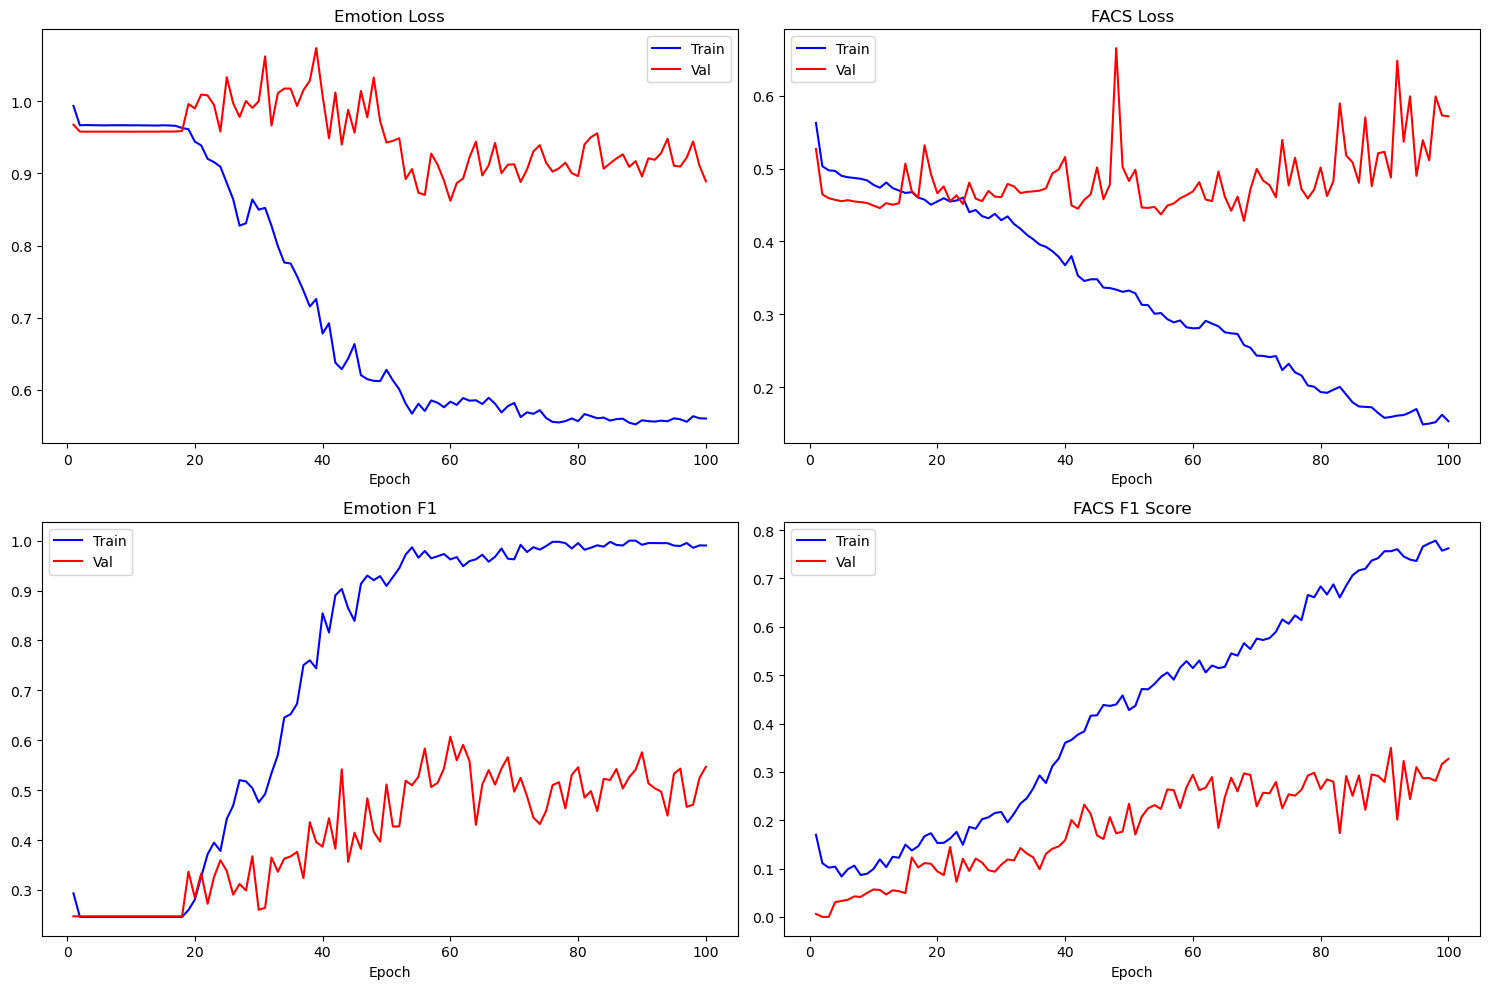

In [30]:
resnet50_trainer.plot_metrics()

#### Resnet50 pretrained

In [31]:
resnet50_pretrained = model.EmotionFACsNet(pretrained=True)

In [32]:
resnet50_pretrained_trainer= trainer.EmotionFACsTrainer(resnet50_pretrained, 'resnet50_pretrained', train_loader, val_loader,  patience = 20)

In [33]:
resnet50_pretrained_trainer.train(num_epochs=100)


Epoch 1/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 1.0429, FACS Loss: 0.6297
Train - Emotion F1: 0.2521, FACS F1: 0.1893
Val - Emotion Loss: 0.9509, FACS Loss: 0.5403
Val - Emotion F1: 0.2472, FACS F1: 0.0450

Epoch 2/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.8997, FACS Loss: 0.5214
Train - Emotion F1: 0.2460, FACS F1: 0.1115
Val - Emotion Loss: 0.9020, FACS Loss: 0.4681
Val - Emotion F1: 0.2472, FACS F1: 0.0576

Epoch 3/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.8053, FACS Loss: 0.4775
Train - Emotion F1: 0.5028, FACS F1: 0.1348
Val - Emotion Loss: 0.8189, FACS Loss: 0.4318
Val - Emotion F1: 0.7454, FACS F1: 0.1331

Epoch 4/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.6773, FACS Loss: 0.4156
Train - Emotion F1: 0.9424, FACS F1: 0.2123
Val - Emotion Loss: 0.6801, FACS Loss: 0.3536
Val - Emotion F1: 0.8635, FACS F1: 0.2273

Epoch 5/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5828, FACS Loss: 0.3491
Train - Emotion F1: 0.9772, FACS F1: 0.3545
Val - Emotion Loss: 0.6708, FACS Loss: 0.3148
Val - Emotion F1: 0.8476, FACS F1: 0.3968

Epoch 6/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5795, FACS Loss: 0.3126
Train - Emotion F1: 0.9711, FACS F1: 0.4331
Val - Emotion Loss: 0.6597, FACS Loss: 0.3017
Val - Emotion F1: 0.8771, FACS F1: 0.4026

Epoch 7/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5786, FACS Loss: 0.3028
Train - Emotion F1: 0.9702, FACS F1: 0.4460
Val - Emotion Loss: 0.6262, FACS Loss: 0.2852
Val - Emotion F1: 0.9142, FACS F1: 0.4178

Epoch 8/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5750, FACS Loss: 0.2777
Train - Emotion F1: 0.9835, FACS F1: 0.4884
Val - Emotion Loss: 0.6468, FACS Loss: 0.2826
Val - Emotion F1: 0.8864, FACS F1: 0.4419

Epoch 9/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5749, FACS Loss: 0.2678
Train - Emotion F1: 0.9735, FACS F1: 0.5116
Val - Emotion Loss: 0.6825, FACS Loss: 0.2990
Val - Emotion F1: 0.8590, FACS F1: 0.4429

Epoch 10/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5726, FACS Loss: 0.2456
Train - Emotion F1: 0.9786, FACS F1: 0.5542
Val - Emotion Loss: 0.6289, FACS Loss: 0.2526
Val - Emotion F1: 0.9125, FACS F1: 0.5222

Epoch 11/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.54it/s]


Train - Emotion Loss: 0.5672, FACS Loss: 0.2337
Train - Emotion F1: 0.9879, FACS F1: 0.5754
Val - Emotion Loss: 0.6680, FACS Loss: 0.2454
Val - Emotion F1: 0.8235, FACS F1: 0.5340

Epoch 12/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5656, FACS Loss: 0.2131
Train - Emotion F1: 0.9853, FACS F1: 0.6023
Val - Emotion Loss: 0.6659, FACS Loss: 0.2432
Val - Emotion F1: 0.8695, FACS F1: 0.5468

Epoch 13/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5691, FACS Loss: 0.1996
Train - Emotion F1: 0.9807, FACS F1: 0.6324
Val - Emotion Loss: 0.6437, FACS Loss: 0.2665
Val - Emotion F1: 0.9117, FACS F1: 0.5076

Epoch 14/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5625, FACS Loss: 0.1936
Train - Emotion F1: 0.9905, FACS F1: 0.6613
Val - Emotion Loss: 0.6926, FACS Loss: 0.2372
Val - Emotion F1: 0.8271, FACS F1: 0.5963

Epoch 15/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5639, FACS Loss: 0.1707
Train - Emotion F1: 0.9857, FACS F1: 0.7151
Val - Emotion Loss: 0.6472, FACS Loss: 0.2404
Val - Emotion F1: 0.8950, FACS F1: 0.5379

Epoch 16/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5585, FACS Loss: 0.1648
Train - Emotion F1: 0.9976, FACS F1: 0.7330
Val - Emotion Loss: 0.6440, FACS Loss: 0.2118
Val - Emotion F1: 0.8936, FACS F1: 0.6206

Epoch 17/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5547, FACS Loss: 0.1625
Train - Emotion F1: 1.0000, FACS F1: 0.7494
Val - Emotion Loss: 0.6323, FACS Loss: 0.2218
Val - Emotion F1: 0.9034, FACS F1: 0.5551

Epoch 18/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5532, FACS Loss: 0.1452
Train - Emotion F1: 1.0000, FACS F1: 0.7833
Val - Emotion Loss: 0.6327, FACS Loss: 0.2084
Val - Emotion F1: 0.9131, FACS F1: 0.6389

Epoch 19/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5526, FACS Loss: 0.1385
Train - Emotion F1: 1.0000, FACS F1: 0.7868
Val - Emotion Loss: 0.6451, FACS Loss: 0.2047
Val - Emotion F1: 0.8851, FACS F1: 0.6166

Epoch 20/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5543, FACS Loss: 0.1221
Train - Emotion F1: 0.9975, FACS F1: 0.8089
Val - Emotion Loss: 0.6463, FACS Loss: 0.2120
Val - Emotion F1: 0.8915, FACS F1: 0.6070

Epoch 21/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5571, FACS Loss: 0.1191
Train - Emotion F1: 0.9951, FACS F1: 0.8228
Val - Emotion Loss: 0.6223, FACS Loss: 0.2218
Val - Emotion F1: 0.9125, FACS F1: 0.6108

Epoch 22/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5547, FACS Loss: 0.1092
Train - Emotion F1: 0.9964, FACS F1: 0.8484
Val - Emotion Loss: 0.6134, FACS Loss: 0.2189
Val - Emotion F1: 0.9305, FACS F1: 0.6419

Epoch 23/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5530, FACS Loss: 0.1030
Train - Emotion F1: 1.0000, FACS F1: 0.8586
Val - Emotion Loss: 0.6197, FACS Loss: 0.2159
Val - Emotion F1: 0.9284, FACS F1: 0.6695

Epoch 24/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5527, FACS Loss: 0.0936
Train - Emotion F1: 1.0000, FACS F1: 0.8793
Val - Emotion Loss: 0.6268, FACS Loss: 0.2292
Val - Emotion F1: 0.9125, FACS F1: 0.6312

Epoch 25/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5550, FACS Loss: 0.0860
Train - Emotion F1: 0.9975, FACS F1: 0.8788
Val - Emotion Loss: 0.6255, FACS Loss: 0.2173
Val - Emotion F1: 0.9125, FACS F1: 0.7066

Epoch 26/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5519, FACS Loss: 0.0802
Train - Emotion F1: 1.0000, FACS F1: 0.9028
Val - Emotion Loss: 0.6317, FACS Loss: 0.2221
Val - Emotion F1: 0.9036, FACS F1: 0.6453

Epoch 27/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5527, FACS Loss: 0.0773
Train - Emotion F1: 1.0000, FACS F1: 0.9011
Val - Emotion Loss: 0.6324, FACS Loss: 0.2312
Val - Emotion F1: 0.8950, FACS F1: 0.6417

Epoch 28/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5544, FACS Loss: 0.0785
Train - Emotion F1: 1.0000, FACS F1: 0.9133
Val - Emotion Loss: 0.6209, FACS Loss: 0.2222
Val - Emotion F1: 0.9184, FACS F1: 0.6641

Epoch 29/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5533, FACS Loss: 0.0758
Train - Emotion F1: 1.0000, FACS F1: 0.9034
Val - Emotion Loss: 0.6345, FACS Loss: 0.2286
Val - Emotion F1: 0.9000, FACS F1: 0.6569

Epoch 30/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5522, FACS Loss: 0.0714
Train - Emotion F1: 1.0000, FACS F1: 0.9207
Val - Emotion Loss: 0.6324, FACS Loss: 0.2214
Val - Emotion F1: 0.9000, FACS F1: 0.6361

Epoch 31/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0654
Train - Emotion F1: 1.0000, FACS F1: 0.9150
Val - Emotion Loss: 0.6424, FACS Loss: 0.2284
Val - Emotion F1: 0.8916, FACS F1: 0.6621

Epoch 32/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5526, FACS Loss: 0.0590
Train - Emotion F1: 1.0000, FACS F1: 0.9336
Val - Emotion Loss: 0.6294, FACS Loss: 0.2173
Val - Emotion F1: 0.9000, FACS F1: 0.6668

Epoch 33/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5532, FACS Loss: 0.0546
Train - Emotion F1: 0.9977, FACS F1: 0.9405
Val - Emotion Loss: 0.6345, FACS Loss: 0.2082
Val - Emotion F1: 0.8851, FACS F1: 0.6841

Epoch 34/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5531, FACS Loss: 0.0552
Train - Emotion F1: 1.0000, FACS F1: 0.9389
Val - Emotion Loss: 0.6391, FACS Loss: 0.2186
Val - Emotion F1: 0.8900, FACS F1: 0.6934

Epoch 35/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5521, FACS Loss: 0.0485
Train - Emotion F1: 1.0000, FACS F1: 0.9538
Val - Emotion Loss: 0.6360, FACS Loss: 0.2322
Val - Emotion F1: 0.9068, FACS F1: 0.7026

Epoch 36/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0522
Train - Emotion F1: 1.0000, FACS F1: 0.9427
Val - Emotion Loss: 0.6177, FACS Loss: 0.2417
Val - Emotion F1: 0.9242, FACS F1: 0.6919

Epoch 37/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5524, FACS Loss: 0.0457
Train - Emotion F1: 1.0000, FACS F1: 0.9588
Val - Emotion Loss: 0.6475, FACS Loss: 0.2543
Val - Emotion F1: 0.8884, FACS F1: 0.6339

Epoch 38/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0461
Train - Emotion F1: 1.0000, FACS F1: 0.9492
Val - Emotion Loss: 0.6453, FACS Loss: 0.2412
Val - Emotion F1: 0.8884, FACS F1: 0.6653

Epoch 39/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5522, FACS Loss: 0.0412
Train - Emotion F1: 1.0000, FACS F1: 0.9639
Val - Emotion Loss: 0.6383, FACS Loss: 0.2338
Val - Emotion F1: 0.8916, FACS F1: 0.6707

Epoch 40/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5516, FACS Loss: 0.0376
Train - Emotion F1: 1.0000, FACS F1: 0.9651
Val - Emotion Loss: 0.6400, FACS Loss: 0.2381
Val - Emotion F1: 0.8950, FACS F1: 0.6621

Epoch 41/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5517, FACS Loss: 0.0368
Train - Emotion F1: 1.0000, FACS F1: 0.9635
Val - Emotion Loss: 0.6403, FACS Loss: 0.2511
Val - Emotion F1: 0.8950, FACS F1: 0.6784

Epoch 42/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5516, FACS Loss: 0.0389
Train - Emotion F1: 1.0000, FACS F1: 0.9577
Val - Emotion Loss: 0.6326, FACS Loss: 0.2481
Val - Emotion F1: 0.9036, FACS F1: 0.6872

Epoch 43/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5523, FACS Loss: 0.0345
Train - Emotion F1: 1.0000, FACS F1: 0.9661
Val - Emotion Loss: 0.6318, FACS Loss: 0.2518
Val - Emotion F1: 0.9036, FACS F1: 0.6666

Epoch 44/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5515, FACS Loss: 0.0366
Train - Emotion F1: 1.0000, FACS F1: 0.9557
Val - Emotion Loss: 0.6322, FACS Loss: 0.2487
Val - Emotion F1: 0.9036, FACS F1: 0.6827

Epoch 45/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5517, FACS Loss: 0.0291
Train - Emotion F1: 1.0000, FACS F1: 0.9733
Val - Emotion Loss: 0.6262, FACS Loss: 0.2495
Val - Emotion F1: 0.9036, FACS F1: 0.6863
Early stop at epoch 45
Best Val - Emotion Loss: 0.6255, Best FACS Loss: 0.2173
Best Val - Emotion F1: 0.9125, Best FACS F1: 0.7066


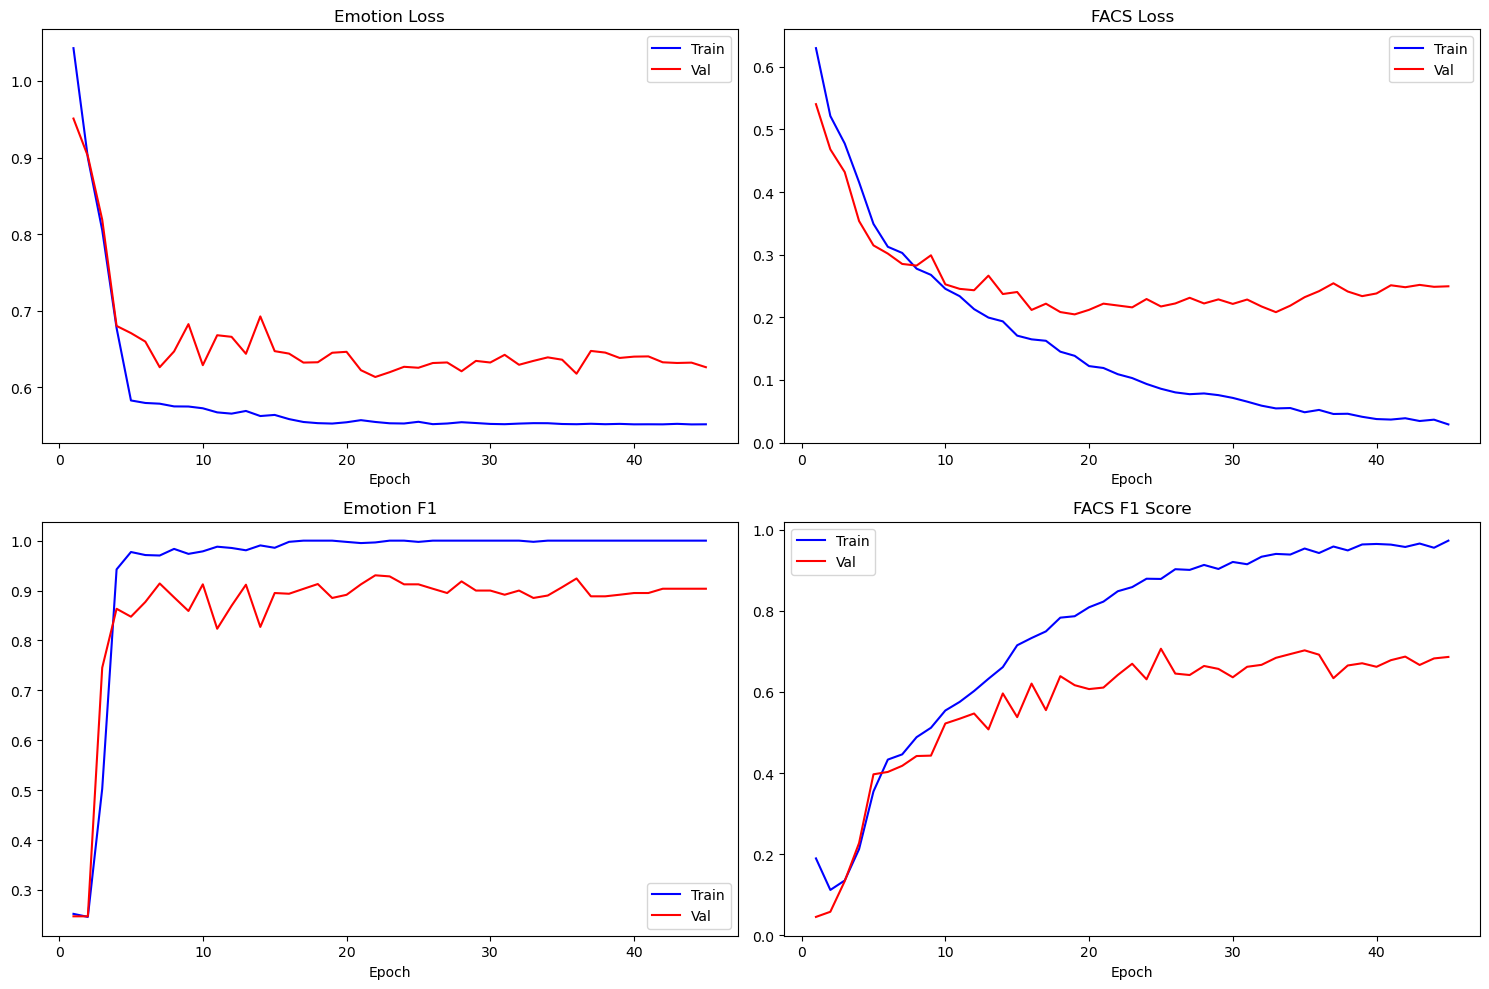

In [34]:
resnet50_pretrained_trainer.plot_metrics()

##### With Augmented Training dataset

In [35]:
aug_resnet50_pretrained = model.EmotionFACsNet(pretrained=True)

In [36]:
aug_resnet50_pretrained_trainer= trainer.EmotionFACsTrainer(aug_resnet50_pretrained, 'aug_resnet50_pretrained', aug_train_loader, val_loader, patience = 20)

In [37]:
aug_resnet50_pretrained_trainer.train(num_epochs=100)


Epoch 1/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 1.0410, FACS Loss: 0.6560
Train - Emotion F1: 0.2729, FACS F1: 0.2343
Val - Emotion Loss: 0.9690, FACS Loss: 0.5919
Val - Emotion F1: 0.2472, FACS F1: 0.0933

Epoch 2/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.9014, FACS Loss: 0.5511
Train - Emotion F1: 0.2460, FACS F1: 0.1093
Val - Emotion Loss: 0.8992, FACS Loss: 0.4853
Val - Emotion F1: 0.2472, FACS F1: 0.0534

Epoch 3/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.8084, FACS Loss: 0.5035
Train - Emotion F1: 0.4828, FACS F1: 0.1310
Val - Emotion Loss: 0.7964, FACS Loss: 0.4455
Val - Emotion F1: 0.5523, FACS F1: 0.1603

Epoch 4/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.7157, FACS Loss: 0.4467
Train - Emotion F1: 0.8052, FACS F1: 0.1856
Val - Emotion Loss: 0.7095, FACS Loss: 0.3692
Val - Emotion F1: 0.8682, FACS F1: 0.2970

Epoch 5/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.6280, FACS Loss: 0.3827
Train - Emotion F1: 0.9502, FACS F1: 0.3201
Val - Emotion Loss: 0.6499, FACS Loss: 0.3271
Val - Emotion F1: 0.9039, FACS F1: 0.3517

Epoch 6/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5830, FACS Loss: 0.3360
Train - Emotion F1: 0.9667, FACS F1: 0.4004
Val - Emotion Loss: 0.6515, FACS Loss: 0.3024
Val - Emotion F1: 0.9054, FACS F1: 0.4159

Epoch 7/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5711, FACS Loss: 0.3088
Train - Emotion F1: 0.9856, FACS F1: 0.4499
Val - Emotion Loss: 0.6858, FACS Loss: 0.2996
Val - Emotion F1: 0.8625, FACS F1: 0.3981

Epoch 8/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5900, FACS Loss: 0.2987
Train - Emotion F1: 0.9636, FACS F1: 0.4709
Val - Emotion Loss: 0.6658, FACS Loss: 0.2854
Val - Emotion F1: 0.8833, FACS F1: 0.4222

Epoch 9/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5624, FACS Loss: 0.2739
Train - Emotion F1: 0.9892, FACS F1: 0.4973
Val - Emotion Loss: 0.6323, FACS Loss: 0.2726
Val - Emotion F1: 0.9125, FACS F1: 0.4794

Epoch 10/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5643, FACS Loss: 0.2547
Train - Emotion F1: 0.9868, FACS F1: 0.5384
Val - Emotion Loss: 0.6152, FACS Loss: 0.2533
Val - Emotion F1: 0.9215, FACS F1: 0.5200

Epoch 11/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5625, FACS Loss: 0.2277
Train - Emotion F1: 0.9917, FACS F1: 0.5650
Val - Emotion Loss: 0.6325, FACS Loss: 0.2460
Val - Emotion F1: 0.9125, FACS F1: 0.5256

Epoch 12/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5613, FACS Loss: 0.2096
Train - Emotion F1: 0.9951, FACS F1: 0.5924
Val - Emotion Loss: 0.6282, FACS Loss: 0.2400
Val - Emotion F1: 0.9215, FACS F1: 0.5484

Epoch 13/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5663, FACS Loss: 0.2055
Train - Emotion F1: 0.9852, FACS F1: 0.6389
Val - Emotion Loss: 0.6293, FACS Loss: 0.2222
Val - Emotion F1: 0.9036, FACS F1: 0.5651

Epoch 14/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5618, FACS Loss: 0.1909
Train - Emotion F1: 0.9902, FACS F1: 0.6684
Val - Emotion Loss: 0.6265, FACS Loss: 0.2336
Val - Emotion F1: 0.9190, FACS F1: 0.5456

Epoch 15/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5562, FACS Loss: 0.1811
Train - Emotion F1: 0.9975, FACS F1: 0.6953
Val - Emotion Loss: 0.6180, FACS Loss: 0.2220
Val - Emotion F1: 0.9215, FACS F1: 0.5753

Epoch 16/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5536, FACS Loss: 0.1613
Train - Emotion F1: 1.0000, FACS F1: 0.7182
Val - Emotion Loss: 0.6283, FACS Loss: 0.2220
Val - Emotion F1: 0.9125, FACS F1: 0.5945

Epoch 17/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5530, FACS Loss: 0.1512
Train - Emotion F1: 1.0000, FACS F1: 0.7509
Val - Emotion Loss: 0.6112, FACS Loss: 0.2119
Val - Emotion F1: 0.9377, FACS F1: 0.6237

Epoch 18/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5530, FACS Loss: 0.1354
Train - Emotion F1: 1.0000, FACS F1: 0.7845
Val - Emotion Loss: 0.6091, FACS Loss: 0.2107
Val - Emotion F1: 0.9377, FACS F1: 0.6139

Epoch 19/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5537, FACS Loss: 0.1275
Train - Emotion F1: 1.0000, FACS F1: 0.7896
Val - Emotion Loss: 0.6188, FACS Loss: 0.2143
Val - Emotion F1: 0.9305, FACS F1: 0.6550

Epoch 20/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5549, FACS Loss: 0.1172
Train - Emotion F1: 0.9976, FACS F1: 0.8457
Val - Emotion Loss: 0.6333, FACS Loss: 0.2302
Val - Emotion F1: 0.9036, FACS F1: 0.6461

Epoch 21/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5545, FACS Loss: 0.1189
Train - Emotion F1: 0.9977, FACS F1: 0.8385
Val - Emotion Loss: 0.6137, FACS Loss: 0.2178
Val - Emotion F1: 0.9215, FACS F1: 0.6902

Epoch 22/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5551, FACS Loss: 0.1124
Train - Emotion F1: 0.9953, FACS F1: 0.8544
Val - Emotion Loss: 0.6288, FACS Loss: 0.2219
Val - Emotion F1: 0.9125, FACS F1: 0.6645

Epoch 23/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.5531, FACS Loss: 0.1031
Train - Emotion F1: 1.0000, FACS F1: 0.8506
Val - Emotion Loss: 0.6076, FACS Loss: 0.2144
Val - Emotion F1: 0.9377, FACS F1: 0.6926

Epoch 24/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5548, FACS Loss: 0.1000
Train - Emotion F1: 0.9976, FACS F1: 0.8581
Val - Emotion Loss: 0.6178, FACS Loss: 0.2179
Val - Emotion F1: 0.9242, FACS F1: 0.7310

Epoch 25/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5537, FACS Loss: 0.0920
Train - Emotion F1: 0.9975, FACS F1: 0.8712
Val - Emotion Loss: 0.6462, FACS Loss: 0.2407
Val - Emotion F1: 0.8984, FACS F1: 0.6792

Epoch 26/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5600, FACS Loss: 0.0891
Train - Emotion F1: 0.9929, FACS F1: 0.8803
Val - Emotion Loss: 0.6309, FACS Loss: 0.2320
Val - Emotion F1: 0.8966, FACS F1: 0.6938

Epoch 27/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5545, FACS Loss: 0.0795
Train - Emotion F1: 0.9976, FACS F1: 0.9004
Val - Emotion Loss: 0.6215, FACS Loss: 0.2343
Val - Emotion F1: 0.9125, FACS F1: 0.6770

Epoch 28/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5521, FACS Loss: 0.0760
Train - Emotion F1: 1.0000, FACS F1: 0.8969
Val - Emotion Loss: 0.6205, FACS Loss: 0.2279
Val - Emotion F1: 0.9093, FACS F1: 0.7541

Epoch 29/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.53it/s]


Train - Emotion Loss: 0.5550, FACS Loss: 0.0786
Train - Emotion F1: 0.9977, FACS F1: 0.8988
Val - Emotion Loss: 0.6164, FACS Loss: 0.2353
Val - Emotion F1: 0.9215, FACS F1: 0.6740

Epoch 30/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.53it/s]


Train - Emotion Loss: 0.5529, FACS Loss: 0.0696
Train - Emotion F1: 0.9976, FACS F1: 0.9169
Val - Emotion Loss: 0.6199, FACS Loss: 0.2464
Val - Emotion F1: 0.9215, FACS F1: 0.6960

Epoch 31/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.53it/s]


Train - Emotion Loss: 0.5550, FACS Loss: 0.0670
Train - Emotion F1: 0.9953, FACS F1: 0.9257
Val - Emotion Loss: 0.6282, FACS Loss: 0.2388
Val - Emotion F1: 0.9125, FACS F1: 0.6745

Epoch 32/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5527, FACS Loss: 0.0632
Train - Emotion F1: 1.0000, FACS F1: 0.9239
Val - Emotion Loss: 0.6457, FACS Loss: 0.2392
Val - Emotion F1: 0.8950, FACS F1: 0.6979

Epoch 33/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.47it/s]


Train - Emotion Loss: 0.5523, FACS Loss: 0.0647
Train - Emotion F1: 1.0000, FACS F1: 0.9193
Val - Emotion Loss: 0.6416, FACS Loss: 0.2378
Val - Emotion F1: 0.8950, FACS F1: 0.6916

Epoch 34/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5520, FACS Loss: 0.0596
Train - Emotion F1: 1.0000, FACS F1: 0.9382
Val - Emotion Loss: 0.6307, FACS Loss: 0.2357
Val - Emotion F1: 0.8950, FACS F1: 0.6870

Epoch 35/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5526, FACS Loss: 0.0526
Train - Emotion F1: 1.0000, FACS F1: 0.9450
Val - Emotion Loss: 0.6310, FACS Loss: 0.2312
Val - Emotion F1: 0.9068, FACS F1: 0.6940

Epoch 36/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.55it/s]


Train - Emotion Loss: 0.5519, FACS Loss: 0.0468
Train - Emotion F1: 1.0000, FACS F1: 0.9602
Val - Emotion Loss: 0.6419, FACS Loss: 0.2383
Val - Emotion F1: 0.8829, FACS F1: 0.6974

Epoch 37/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.55it/s]


Train - Emotion Loss: 0.5517, FACS Loss: 0.0459
Train - Emotion F1: 1.0000, FACS F1: 0.9520
Val - Emotion Loss: 0.6342, FACS Loss: 0.2337
Val - Emotion F1: 0.9036, FACS F1: 0.6754

Epoch 38/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5548, FACS Loss: 0.0490
Train - Emotion F1: 0.9964, FACS F1: 0.9466
Val - Emotion Loss: 0.6254, FACS Loss: 0.2332
Val - Emotion F1: 0.9154, FACS F1: 0.6758

Epoch 39/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5530, FACS Loss: 0.0460
Train - Emotion F1: 0.9975, FACS F1: 0.9523
Val - Emotion Loss: 0.6323, FACS Loss: 0.2463
Val - Emotion F1: 0.9003, FACS F1: 0.6724

Epoch 40/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5517, FACS Loss: 0.0415
Train - Emotion F1: 1.0000, FACS F1: 0.9597
Val - Emotion Loss: 0.6465, FACS Loss: 0.2449
Val - Emotion F1: 0.8829, FACS F1: 0.6750

Epoch 41/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5523, FACS Loss: 0.0409
Train - Emotion F1: 1.0000, FACS F1: 0.9591
Val - Emotion Loss: 0.6370, FACS Loss: 0.2569
Val - Emotion F1: 0.9003, FACS F1: 0.6631

Epoch 42/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5519, FACS Loss: 0.0360
Train - Emotion F1: 1.0000, FACS F1: 0.9585
Val - Emotion Loss: 0.6289, FACS Loss: 0.2496
Val - Emotion F1: 0.9003, FACS F1: 0.6728

Epoch 43/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.51it/s]


Train - Emotion Loss: 0.5517, FACS Loss: 0.0352
Train - Emotion F1: 1.0000, FACS F1: 0.9669
Val - Emotion Loss: 0.6188, FACS Loss: 0.2406
Val - Emotion F1: 0.9242, FACS F1: 0.7098

Epoch 44/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5516, FACS Loss: 0.0348
Train - Emotion F1: 1.0000, FACS F1: 0.9699
Val - Emotion Loss: 0.6191, FACS Loss: 0.2516
Val - Emotion F1: 0.9215, FACS F1: 0.7077

Epoch 45/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5516, FACS Loss: 0.0314
Train - Emotion F1: 1.0000, FACS F1: 0.9617
Val - Emotion Loss: 0.6209, FACS Loss: 0.2578
Val - Emotion F1: 0.9093, FACS F1: 0.6979

Epoch 46/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5517, FACS Loss: 0.0308
Train - Emotion F1: 1.0000, FACS F1: 0.9673
Val - Emotion Loss: 0.6172, FACS Loss: 0.2516
Val - Emotion F1: 0.9332, FACS F1: 0.6910

Epoch 47/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0298
Train - Emotion F1: 1.0000, FACS F1: 0.9769
Val - Emotion Loss: 0.6322, FACS Loss: 0.2541
Val - Emotion F1: 0.9068, FACS F1: 0.6994

Epoch 48/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.53it/s]


Train - Emotion Loss: 0.5523, FACS Loss: 0.0285
Train - Emotion F1: 1.0000, FACS F1: 0.9800
Val - Emotion Loss: 0.6091, FACS Loss: 0.2694
Val - Emotion F1: 0.9332, FACS F1: 0.7068
Early stop at epoch 48
Best Val - Emotion Loss: 0.6205, Best FACS Loss: 0.2279
Best Val - Emotion F1: 0.9093, Best FACS F1: 0.7541


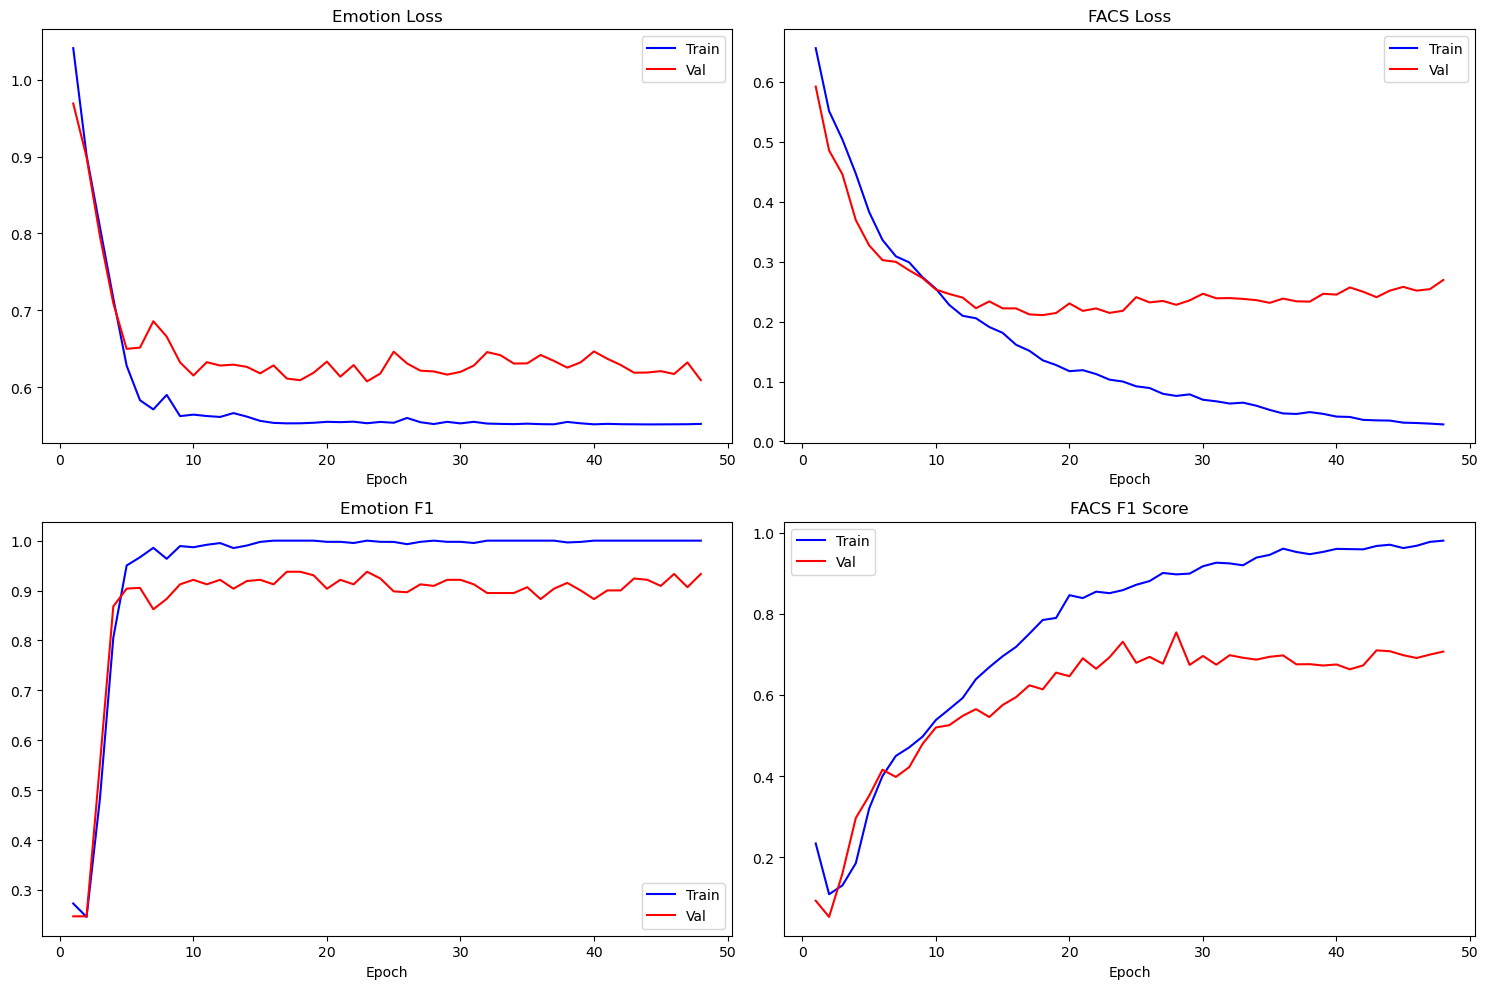

In [38]:
aug_resnet50_pretrained_trainer.plot_metrics()

#### ResNet18

In [39]:
resnet18_pretrained = model.EmotionFACsNet(backbone_name='resnet18', pretrained=True)

In [40]:
resnet18_pretrained_trainer= trainer.EmotionFACsTrainer(resnet18_pretrained,'resnet18_pretrained', train_loader, val_loader, patience = 20)

In [41]:
resnet18_pretrained_trainer.train(num_epochs=100)


Epoch 1/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.62it/s]


Train - Emotion Loss: 0.9702, FACS Loss: 0.6274
Train - Emotion F1: 0.4190, FACS F1: 0.2429
Val - Emotion Loss: 0.8802, FACS Loss: 0.5467
Val - Emotion F1: 0.5143, FACS F1: 0.0644

Epoch 2/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.25it/s]


Train - Emotion Loss: 0.8044, FACS Loss: 0.5011
Train - Emotion F1: 0.5752, FACS F1: 0.1698
Val - Emotion Loss: 0.7821, FACS Loss: 0.4264
Val - Emotion F1: 0.5427, FACS F1: 0.1298

Epoch 3/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.30it/s]


Train - Emotion Loss: 0.7063, FACS Loss: 0.4210
Train - Emotion F1: 0.8338, FACS F1: 0.2582
Val - Emotion Loss: 0.6907, FACS Loss: 0.3590
Val - Emotion F1: 0.8371, FACS F1: 0.2889

Epoch 4/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.32it/s]


Train - Emotion Loss: 0.6150, FACS Loss: 0.3702
Train - Emotion F1: 0.9687, FACS F1: 0.3246
Val - Emotion Loss: 0.6667, FACS Loss: 0.3286
Val - Emotion F1: 0.8968, FACS F1: 0.3370

Epoch 5/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.38it/s]


Train - Emotion Loss: 0.5882, FACS Loss: 0.3362
Train - Emotion F1: 0.9774, FACS F1: 0.4053
Val - Emotion Loss: 0.6654, FACS Loss: 0.3066
Val - Emotion F1: 0.8608, FACS F1: 0.4049

Epoch 6/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.35it/s]


Train - Emotion Loss: 0.5715, FACS Loss: 0.3055
Train - Emotion F1: 0.9881, FACS F1: 0.4504
Val - Emotion Loss: 0.6606, FACS Loss: 0.2824
Val - Emotion F1: 0.8746, FACS F1: 0.4377

Epoch 7/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.32it/s]


Train - Emotion Loss: 0.5669, FACS Loss: 0.2846
Train - Emotion F1: 0.9929, FACS F1: 0.4766
Val - Emotion Loss: 0.6614, FACS Loss: 0.2649
Val - Emotion F1: 0.8593, FACS F1: 0.4501

Epoch 8/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.33it/s]


Train - Emotion Loss: 0.5626, FACS Loss: 0.2720
Train - Emotion F1: 0.9926, FACS F1: 0.5115
Val - Emotion Loss: 0.6495, FACS Loss: 0.2575
Val - Emotion F1: 0.8903, FACS F1: 0.4702

Epoch 9/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.31it/s]


Train - Emotion Loss: 0.5621, FACS Loss: 0.2428
Train - Emotion F1: 0.9976, FACS F1: 0.5492
Val - Emotion Loss: 0.6418, FACS Loss: 0.2438
Val - Emotion F1: 0.9093, FACS F1: 0.5428

Epoch 10/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.29it/s]


Train - Emotion Loss: 0.5660, FACS Loss: 0.2270
Train - Emotion F1: 0.9869, FACS F1: 0.5735
Val - Emotion Loss: 0.6537, FACS Loss: 0.2322
Val - Emotion F1: 0.8891, FACS F1: 0.5428

Epoch 11/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.34it/s]


Train - Emotion Loss: 0.5635, FACS Loss: 0.2134
Train - Emotion F1: 0.9929, FACS F1: 0.5920
Val - Emotion Loss: 0.6385, FACS Loss: 0.2267
Val - Emotion F1: 0.9085, FACS F1: 0.5318

Epoch 12/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.34it/s]


Train - Emotion Loss: 0.5618, FACS Loss: 0.1959
Train - Emotion F1: 0.9953, FACS F1: 0.6398
Val - Emotion Loss: 0.6544, FACS Loss: 0.2249
Val - Emotion F1: 0.9106, FACS F1: 0.5527

Epoch 13/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.29it/s]


Train - Emotion Loss: 0.5599, FACS Loss: 0.1836
Train - Emotion F1: 0.9953, FACS F1: 0.6652
Val - Emotion Loss: 0.6387, FACS Loss: 0.2215
Val - Emotion F1: 0.9075, FACS F1: 0.5643

Epoch 14/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.28it/s]


Train - Emotion Loss: 0.5651, FACS Loss: 0.1691
Train - Emotion F1: 0.9905, FACS F1: 0.7178
Val - Emotion Loss: 0.6324, FACS Loss: 0.2095
Val - Emotion F1: 0.9290, FACS F1: 0.5876

Epoch 15/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.27it/s]


Train - Emotion Loss: 0.5584, FACS Loss: 0.1597
Train - Emotion F1: 0.9976, FACS F1: 0.7329
Val - Emotion Loss: 0.6282, FACS Loss: 0.2084
Val - Emotion F1: 0.9277, FACS F1: 0.5743

Epoch 16/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.30it/s]


Train - Emotion Loss: 0.5571, FACS Loss: 0.1513
Train - Emotion F1: 0.9976, FACS F1: 0.7472
Val - Emotion Loss: 0.6426, FACS Loss: 0.2155
Val - Emotion F1: 0.8968, FACS F1: 0.5663

Epoch 17/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.34it/s]


Train - Emotion Loss: 0.5576, FACS Loss: 0.1427
Train - Emotion F1: 0.9976, FACS F1: 0.7886
Val - Emotion Loss: 0.6210, FACS Loss: 0.2077
Val - Emotion F1: 0.9290, FACS F1: 0.6057

Epoch 18/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.35it/s]


Train - Emotion Loss: 0.5573, FACS Loss: 0.1295
Train - Emotion F1: 0.9951, FACS F1: 0.8151
Val - Emotion Loss: 0.6395, FACS Loss: 0.2109
Val - Emotion F1: 0.9075, FACS F1: 0.5847

Epoch 19/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.33it/s]


Train - Emotion Loss: 0.5569, FACS Loss: 0.1274
Train - Emotion F1: 0.9976, FACS F1: 0.8239
Val - Emotion Loss: 0.6421, FACS Loss: 0.2011
Val - Emotion F1: 0.9066, FACS F1: 0.6220

Epoch 20/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.34it/s]


Train - Emotion Loss: 0.5563, FACS Loss: 0.1162
Train - Emotion F1: 0.9976, FACS F1: 0.8425
Val - Emotion Loss: 0.6492, FACS Loss: 0.2016
Val - Emotion F1: 0.8956, FACS F1: 0.6316

Epoch 21/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.27it/s]


Train - Emotion Loss: 0.5576, FACS Loss: 0.1143
Train - Emotion F1: 0.9976, FACS F1: 0.8651
Val - Emotion Loss: 0.6350, FACS Loss: 0.2189
Val - Emotion F1: 0.9068, FACS F1: 0.5798

Epoch 22/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.32it/s]


Train - Emotion Loss: 0.5571, FACS Loss: 0.1060
Train - Emotion F1: 0.9977, FACS F1: 0.8599
Val - Emotion Loss: 0.6618, FACS Loss: 0.2178
Val - Emotion F1: 0.8575, FACS F1: 0.6563

Epoch 23/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.21it/s]


Train - Emotion Loss: 0.5557, FACS Loss: 0.1037
Train - Emotion F1: 0.9976, FACS F1: 0.8793
Val - Emotion Loss: 0.6331, FACS Loss: 0.2043
Val - Emotion F1: 0.9093, FACS F1: 0.6081

Epoch 24/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.31it/s]


Train - Emotion Loss: 0.5541, FACS Loss: 0.0918
Train - Emotion F1: 1.0000, FACS F1: 0.8872
Val - Emotion Loss: 0.6312, FACS Loss: 0.1977
Val - Emotion F1: 0.9075, FACS F1: 0.6502

Epoch 25/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.33it/s]


Train - Emotion Loss: 0.5548, FACS Loss: 0.0855
Train - Emotion F1: 0.9976, FACS F1: 0.9016
Val - Emotion Loss: 0.6292, FACS Loss: 0.2090
Val - Emotion F1: 0.9184, FACS F1: 0.6111

Epoch 26/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.25it/s]


Train - Emotion Loss: 0.5535, FACS Loss: 0.0828
Train - Emotion F1: 1.0000, FACS F1: 0.9084
Val - Emotion Loss: 0.6425, FACS Loss: 0.2101
Val - Emotion F1: 0.8950, FACS F1: 0.6612

Epoch 27/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.35it/s]


Train - Emotion Loss: 0.5530, FACS Loss: 0.0721
Train - Emotion F1: 1.0000, FACS F1: 0.9243
Val - Emotion Loss: 0.6352, FACS Loss: 0.2050
Val - Emotion F1: 0.8964, FACS F1: 0.6194

Epoch 28/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.35it/s]


Train - Emotion Loss: 0.5524, FACS Loss: 0.0705
Train - Emotion F1: 1.0000, FACS F1: 0.9266
Val - Emotion Loss: 0.6350, FACS Loss: 0.2132
Val - Emotion F1: 0.9080, FACS F1: 0.6471

Epoch 29/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.31it/s]


Train - Emotion Loss: 0.5532, FACS Loss: 0.0691
Train - Emotion F1: 1.0000, FACS F1: 0.9332
Val - Emotion Loss: 0.6376, FACS Loss: 0.2116
Val - Emotion F1: 0.9184, FACS F1: 0.6199

Epoch 30/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.28it/s]


Train - Emotion Loss: 0.5525, FACS Loss: 0.0654
Train - Emotion F1: 1.0000, FACS F1: 0.9388
Val - Emotion Loss: 0.6413, FACS Loss: 0.2176
Val - Emotion F1: 0.8922, FACS F1: 0.6118

Epoch 31/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.32it/s]


Train - Emotion Loss: 0.5546, FACS Loss: 0.0702
Train - Emotion F1: 1.0000, FACS F1: 0.9201
Val - Emotion Loss: 0.6451, FACS Loss: 0.2138
Val - Emotion F1: 0.8801, FACS F1: 0.6490

Epoch 32/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.36it/s]


Train - Emotion Loss: 0.5580, FACS Loss: 0.0625
Train - Emotion F1: 0.9951, FACS F1: 0.9439
Val - Emotion Loss: 0.6358, FACS Loss: 0.2175
Val - Emotion F1: 0.9192, FACS F1: 0.6695

Epoch 33/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.32it/s]


Train - Emotion Loss: 0.5561, FACS Loss: 0.0578
Train - Emotion F1: 0.9975, FACS F1: 0.9423
Val - Emotion Loss: 0.6426, FACS Loss: 0.2242
Val - Emotion F1: 0.8801, FACS F1: 0.6260

Epoch 34/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.32it/s]


Train - Emotion Loss: 0.5550, FACS Loss: 0.0581
Train - Emotion F1: 0.9976, FACS F1: 0.9443
Val - Emotion Loss: 0.6350, FACS Loss: 0.2203
Val - Emotion F1: 0.9294, FACS F1: 0.6866

Epoch 35/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.32it/s]


Train - Emotion Loss: 0.5545, FACS Loss: 0.0542
Train - Emotion F1: 0.9975, FACS F1: 0.9462
Val - Emotion Loss: 0.6317, FACS Loss: 0.2285
Val - Emotion F1: 0.9039, FACS F1: 0.6197

Epoch 36/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.31it/s]


Train - Emotion Loss: 0.5524, FACS Loss: 0.0526
Train - Emotion F1: 1.0000, FACS F1: 0.9502
Val - Emotion Loss: 0.6268, FACS Loss: 0.2069
Val - Emotion F1: 0.9285, FACS F1: 0.6627

Epoch 37/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.33it/s]


Train - Emotion Loss: 0.5525, FACS Loss: 0.0458
Train - Emotion F1: 1.0000, FACS F1: 0.9698
Val - Emotion Loss: 0.6241, FACS Loss: 0.2172
Val - Emotion F1: 0.9184, FACS F1: 0.6170

Epoch 38/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.32it/s]


Train - Emotion Loss: 0.5525, FACS Loss: 0.0419
Train - Emotion F1: 1.0000, FACS F1: 0.9650
Val - Emotion Loss: 0.6274, FACS Loss: 0.2220
Val - Emotion F1: 0.9080, FACS F1: 0.6392

Epoch 39/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.36it/s]


Train - Emotion Loss: 0.5538, FACS Loss: 0.0423
Train - Emotion F1: 0.9977, FACS F1: 0.9669
Val - Emotion Loss: 0.6380, FACS Loss: 0.2361
Val - Emotion F1: 0.9080, FACS F1: 0.6293

Epoch 40/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.35it/s]


Train - Emotion Loss: 0.5534, FACS Loss: 0.0416
Train - Emotion F1: 1.0000, FACS F1: 0.9565
Val - Emotion Loss: 0.6235, FACS Loss: 0.2340
Val - Emotion F1: 0.9025, FACS F1: 0.6468

Epoch 41/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.33it/s]


Train - Emotion Loss: 0.5528, FACS Loss: 0.0404
Train - Emotion F1: 1.0000, FACS F1: 0.9682
Val - Emotion Loss: 0.6160, FACS Loss: 0.2240
Val - Emotion F1: 0.9377, FACS F1: 0.6682

Epoch 42/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.30it/s]


Train - Emotion Loss: 0.5540, FACS Loss: 0.0395
Train - Emotion F1: 0.9977, FACS F1: 0.9657
Val - Emotion Loss: 0.6594, FACS Loss: 0.2258
Val - Emotion F1: 0.8599, FACS F1: 0.6550

Epoch 43/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.31it/s]


Train - Emotion Loss: 0.5529, FACS Loss: 0.0395
Train - Emotion F1: 1.0000, FACS F1: 0.9680
Val - Emotion Loss: 0.6567, FACS Loss: 0.2599
Val - Emotion F1: 0.8662, FACS F1: 0.6074

Epoch 44/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.33it/s]


Train - Emotion Loss: 0.5519, FACS Loss: 0.0371
Train - Emotion F1: 1.0000, FACS F1: 0.9692
Val - Emotion Loss: 0.6191, FACS Loss: 0.2417
Val - Emotion F1: 0.9260, FACS F1: 0.6077

Epoch 45/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.27it/s]


Train - Emotion Loss: 0.5521, FACS Loss: 0.0333
Train - Emotion F1: 1.0000, FACS F1: 0.9815
Val - Emotion Loss: 0.6228, FACS Loss: 0.2287
Val - Emotion F1: 0.9285, FACS F1: 0.6708

Epoch 46/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.31it/s]


Train - Emotion Loss: 0.5524, FACS Loss: 0.0325
Train - Emotion F1: 1.0000, FACS F1: 0.9785
Val - Emotion Loss: 0.6087, FACS Loss: 0.2315
Val - Emotion F1: 0.9598, FACS F1: 0.6683

Epoch 47/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.30it/s]


Train - Emotion Loss: 0.5520, FACS Loss: 0.0294
Train - Emotion F1: 1.0000, FACS F1: 0.9835
Val - Emotion Loss: 0.6219, FACS Loss: 0.2356
Val - Emotion F1: 0.9260, FACS F1: 0.6389

Epoch 48/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.35it/s]


Train - Emotion Loss: 0.5521, FACS Loss: 0.0287
Train - Emotion F1: 1.0000, FACS F1: 0.9804
Val - Emotion Loss: 0.6232, FACS Loss: 0.2420
Val - Emotion F1: 0.9277, FACS F1: 0.6296

Epoch 49/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.34it/s]


Train - Emotion Loss: 0.5530, FACS Loss: 0.0283
Train - Emotion F1: 0.9975, FACS F1: 0.9764
Val - Emotion Loss: 0.6158, FACS Loss: 0.2467
Val - Emotion F1: 0.9389, FACS F1: 0.6335

Epoch 50/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.37it/s]


Train - Emotion Loss: 0.5520, FACS Loss: 0.0280
Train - Emotion F1: 1.0000, FACS F1: 0.9753
Val - Emotion Loss: 0.6150, FACS Loss: 0.2406
Val - Emotion F1: 0.9389, FACS F1: 0.6489

Epoch 51/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.35it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0238
Train - Emotion F1: 1.0000, FACS F1: 0.9823
Val - Emotion Loss: 0.6099, FACS Loss: 0.2414
Val - Emotion F1: 0.9490, FACS F1: 0.6287

Epoch 52/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.29it/s]


Train - Emotion Loss: 0.5521, FACS Loss: 0.0254
Train - Emotion F1: 1.0000, FACS F1: 0.9796
Val - Emotion Loss: 0.6118, FACS Loss: 0.2447
Val - Emotion F1: 0.9377, FACS F1: 0.6705

Epoch 53/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.30it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0257
Train - Emotion F1: 1.0000, FACS F1: 0.9815
Val - Emotion Loss: 0.6256, FACS Loss: 0.2474
Val - Emotion F1: 0.9057, FACS F1: 0.6807

Epoch 54/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.36it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0241
Train - Emotion F1: 1.0000, FACS F1: 0.9872
Val - Emotion Loss: 0.6170, FACS Loss: 0.2414
Val - Emotion F1: 0.9277, FACS F1: 0.6787

Epoch 55/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.35it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0214
Train - Emotion F1: 1.0000, FACS F1: 0.9862
Val - Emotion Loss: 0.6167, FACS Loss: 0.2546
Val - Emotion F1: 0.9284, FACS F1: 0.6255

Epoch 56/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.35it/s]


Train - Emotion Loss: 0.5519, FACS Loss: 0.0223
Train - Emotion F1: 1.0000, FACS F1: 0.9890
Val - Emotion Loss: 0.6180, FACS Loss: 0.2628
Val - Emotion F1: 0.9277, FACS F1: 0.6451

Epoch 57/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.32it/s]


Train - Emotion Loss: 0.5540, FACS Loss: 0.0240
Train - Emotion F1: 0.9976, FACS F1: 0.9851
Val - Emotion Loss: 0.6356, FACS Loss: 0.2594
Val - Emotion F1: 0.8968, FACS F1: 0.6619

Epoch 58/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.33it/s]


Train - Emotion Loss: 0.5543, FACS Loss: 0.0218
Train - Emotion F1: 0.9964, FACS F1: 0.9891
Val - Emotion Loss: 0.6151, FACS Loss: 0.2506
Val - Emotion F1: 0.9505, FACS F1: 0.6375

Epoch 59/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.35it/s]


Train - Emotion Loss: 0.5519, FACS Loss: 0.0211
Train - Emotion F1: 1.0000, FACS F1: 0.9879
Val - Emotion Loss: 0.6233, FACS Loss: 0.2599
Val - Emotion F1: 0.9080, FACS F1: 0.6205

Epoch 60/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.35it/s]


Train - Emotion Loss: 0.5524, FACS Loss: 0.0215
Train - Emotion F1: 1.0000, FACS F1: 0.9868
Val - Emotion Loss: 0.6138, FACS Loss: 0.2492
Val - Emotion F1: 0.9404, FACS F1: 0.6580

Epoch 61/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.33it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0197
Train - Emotion F1: 1.0000, FACS F1: 0.9902
Val - Emotion Loss: 0.6154, FACS Loss: 0.2544
Val - Emotion F1: 0.9396, FACS F1: 0.6404

Epoch 62/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.28it/s]


Train - Emotion Loss: 0.5531, FACS Loss: 0.0174
Train - Emotion F1: 0.9975, FACS F1: 0.9897
Val - Emotion Loss: 0.6186, FACS Loss: 0.2468
Val - Emotion F1: 0.9319, FACS F1: 0.6744

Epoch 63/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.33it/s]


Train - Emotion Loss: 0.5540, FACS Loss: 0.0201
Train - Emotion F1: 0.9975, FACS F1: 0.9874
Val - Emotion Loss: 0.6324, FACS Loss: 0.2555
Val - Emotion F1: 0.9003, FACS F1: 0.6328

Epoch 64/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.32it/s]


Train - Emotion Loss: 0.5521, FACS Loss: 0.0187
Train - Emotion F1: 1.0000, FACS F1: 0.9926
Val - Emotion Loss: 0.6307, FACS Loss: 0.2504
Val - Emotion F1: 0.9173, FACS F1: 0.6273

Epoch 65/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.33it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0174
Train - Emotion F1: 1.0000, FACS F1: 0.9852
Val - Emotion Loss: 0.6147, FACS Loss: 0.2517
Val - Emotion F1: 0.9277, FACS F1: 0.6734

Epoch 66/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.31it/s]


Train - Emotion Loss: 0.5517, FACS Loss: 0.0174
Train - Emotion F1: 1.0000, FACS F1: 0.9938
Val - Emotion Loss: 0.6108, FACS Loss: 0.2461
Val - Emotion F1: 0.9377, FACS F1: 0.6509
Early stop at epoch 66
Best Val - Emotion Loss: 0.6087, Best FACS Loss: 0.2315
Best Val - Emotion F1: 0.9598, Best FACS F1: 0.6683


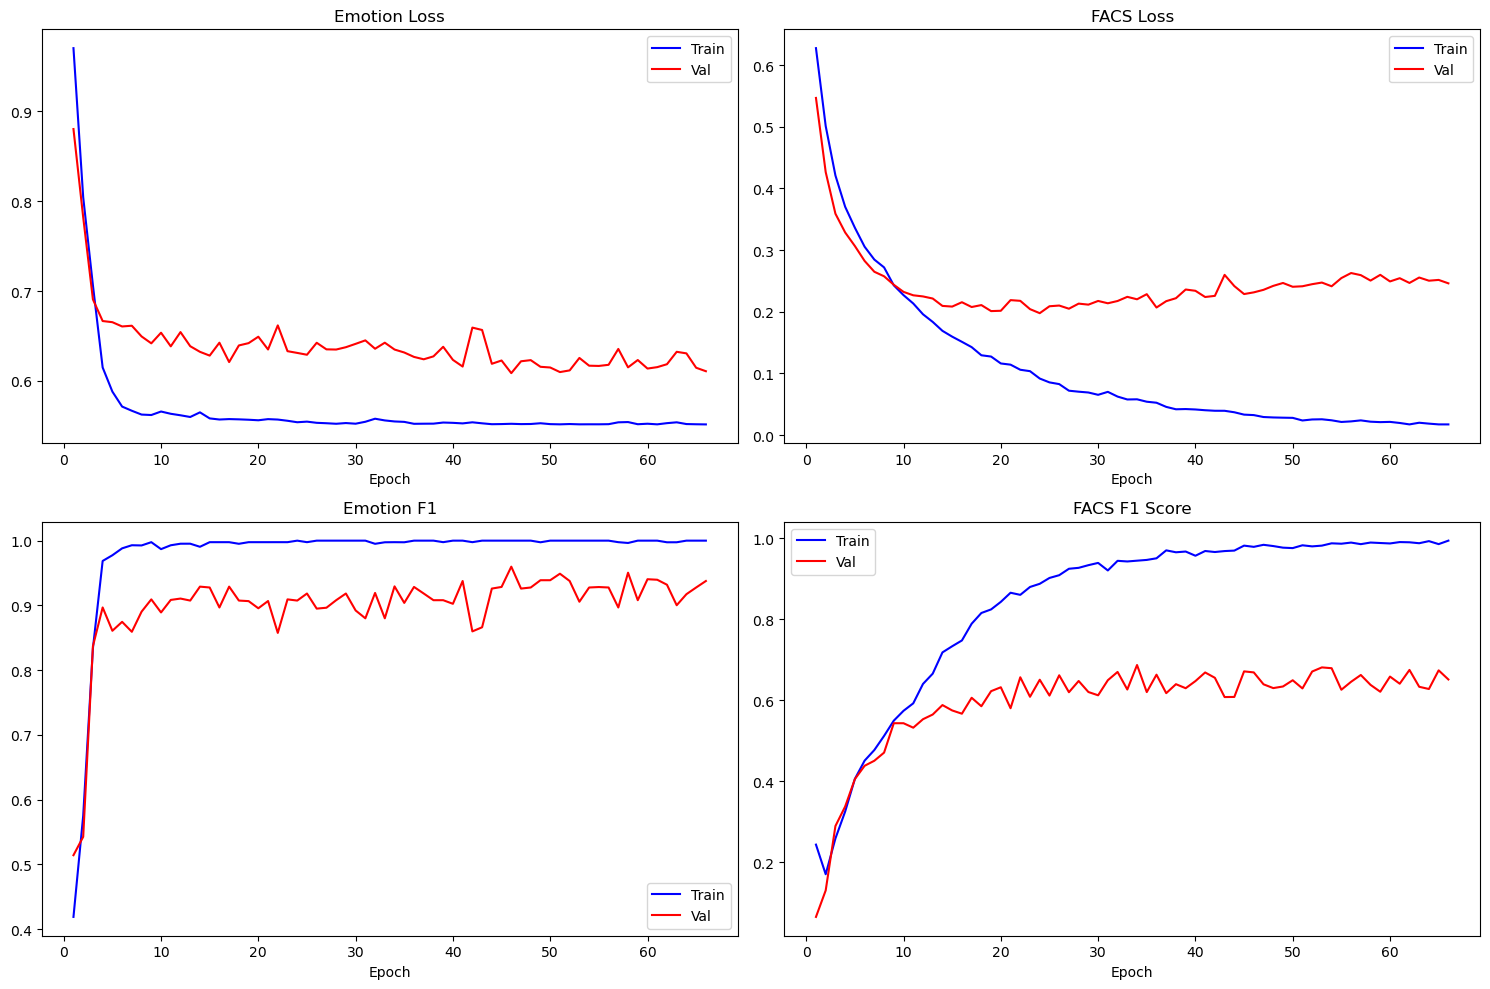

In [42]:
resnet18_pretrained_trainer.plot_metrics()

In [43]:
aug_resnet18_pretrained = model.EmotionFACsNet(pretrained=True)

In [44]:
aug_resnet18_pretrained_trainer= trainer.EmotionFACsTrainer(aug_resnet18_pretrained, 'aug_resnet18_pretrained', aug_train_loader, val_loader, patience = 20)

In [45]:
aug_resnet18_pretrained_trainer.train(num_epochs=100)


Epoch 1/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.46it/s]


Train - Emotion Loss: 1.0480, FACS Loss: 0.6394
Train - Emotion F1: 0.2867, FACS F1: 0.2011
Val - Emotion Loss: 0.9631, FACS Loss: 0.5528
Val - Emotion F1: 0.2472, FACS F1: 0.0635

Epoch 2/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.56it/s]


Train - Emotion Loss: 0.9088, FACS Loss: 0.5324
Train - Emotion F1: 0.2460, FACS F1: 0.1066
Val - Emotion Loss: 0.9269, FACS Loss: 0.4692
Val - Emotion F1: 0.2472, FACS F1: 0.0452

Epoch 3/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.52it/s]


Train - Emotion Loss: 0.8296, FACS Loss: 0.4956
Train - Emotion F1: 0.3566, FACS F1: 0.1122
Val - Emotion Loss: 0.8527, FACS Loss: 0.4504
Val - Emotion F1: 0.4539, FACS F1: 0.1143

Epoch 4/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.7377, FACS Loss: 0.4558
Train - Emotion F1: 0.8882, FACS F1: 0.1523
Val - Emotion Loss: 0.7501, FACS Loss: 0.3929
Val - Emotion F1: 0.8366, FACS F1: 0.1544

Epoch 5/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]


Train - Emotion Loss: 0.6200, FACS Loss: 0.3923
Train - Emotion F1: 0.9524, FACS F1: 0.2572
Val - Emotion Loss: 0.6735, FACS Loss: 0.3296
Val - Emotion F1: 0.8903, FACS F1: 0.3544

Epoch 6/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5743, FACS Loss: 0.3361
Train - Emotion F1: 0.9809, FACS F1: 0.4007
Val - Emotion Loss: 0.7192, FACS Loss: 0.3315
Val - Emotion F1: 0.7894, FACS F1: 0.3830

Epoch 7/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5702, FACS Loss: 0.3018
Train - Emotion F1: 0.9833, FACS F1: 0.4451
Val - Emotion Loss: 0.6429, FACS Loss: 0.2761
Val - Emotion F1: 0.8932, FACS F1: 0.4201

Epoch 8/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5595, FACS Loss: 0.2787
Train - Emotion F1: 0.9976, FACS F1: 0.4788
Val - Emotion Loss: 0.6607, FACS Loss: 0.2714
Val - Emotion F1: 0.8795, FACS F1: 0.5034

Epoch 9/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5736, FACS Loss: 0.2639
Train - Emotion F1: 0.9754, FACS F1: 0.5034
Val - Emotion Loss: 0.6676, FACS Loss: 0.2576
Val - Emotion F1: 0.8768, FACS F1: 0.4922

Epoch 10/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5706, FACS Loss: 0.2404
Train - Emotion F1: 0.9829, FACS F1: 0.5485
Val - Emotion Loss: 0.6593, FACS Loss: 0.2552
Val - Emotion F1: 0.8784, FACS F1: 0.5249

Epoch 11/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5677, FACS Loss: 0.2333
Train - Emotion F1: 0.9876, FACS F1: 0.5646
Val - Emotion Loss: 0.6774, FACS Loss: 0.2266
Val - Emotion F1: 0.8919, FACS F1: 0.5624

Epoch 12/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5597, FACS Loss: 0.2090
Train - Emotion F1: 0.9975, FACS F1: 0.5997
Val - Emotion Loss: 0.7025, FACS Loss: 0.2238
Val - Emotion F1: 0.8190, FACS F1: 0.5656

Epoch 13/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5614, FACS Loss: 0.1972
Train - Emotion F1: 0.9929, FACS F1: 0.6286
Val - Emotion Loss: 0.6719, FACS Loss: 0.2315
Val - Emotion F1: 0.8801, FACS F1: 0.5402

Epoch 14/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5618, FACS Loss: 0.1888
Train - Emotion F1: 0.9930, FACS F1: 0.6743
Val - Emotion Loss: 0.6806, FACS Loss: 0.2183
Val - Emotion F1: 0.8511, FACS F1: 0.5753

Epoch 15/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5562, FACS Loss: 0.1689
Train - Emotion F1: 1.0000, FACS F1: 0.7032
Val - Emotion Loss: 0.6676, FACS Loss: 0.2116
Val - Emotion F1: 0.8710, FACS F1: 0.5748

Epoch 16/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5541, FACS Loss: 0.1581
Train - Emotion F1: 1.0000, FACS F1: 0.7409
Val - Emotion Loss: 0.6577, FACS Loss: 0.2015
Val - Emotion F1: 0.8884, FACS F1: 0.6591

Epoch 17/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5574, FACS Loss: 0.1509
Train - Emotion F1: 0.9929, FACS F1: 0.7631
Val - Emotion Loss: 0.6422, FACS Loss: 0.1999
Val - Emotion F1: 0.9059, FACS F1: 0.6112

Epoch 18/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5568, FACS Loss: 0.1484
Train - Emotion F1: 0.9975, FACS F1: 0.7673
Val - Emotion Loss: 0.6587, FACS Loss: 0.2226
Val - Emotion F1: 0.8940, FACS F1: 0.5455

Epoch 19/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5557, FACS Loss: 0.1350
Train - Emotion F1: 0.9977, FACS F1: 0.7976
Val - Emotion Loss: 0.6601, FACS Loss: 0.1984
Val - Emotion F1: 0.8833, FACS F1: 0.6293

Epoch 20/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5534, FACS Loss: 0.1307
Train - Emotion F1: 1.0000, FACS F1: 0.8072
Val - Emotion Loss: 0.6696, FACS Loss: 0.2005
Val - Emotion F1: 0.8766, FACS F1: 0.6968

Epoch 21/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5543, FACS Loss: 0.1220
Train - Emotion F1: 0.9975, FACS F1: 0.8244
Val - Emotion Loss: 0.6796, FACS Loss: 0.2168
Val - Emotion F1: 0.8565, FACS F1: 0.6744

Epoch 22/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5534, FACS Loss: 0.1113
Train - Emotion F1: 1.0000, FACS F1: 0.8352
Val - Emotion Loss: 0.6708, FACS Loss: 0.2132
Val - Emotion F1: 0.8630, FACS F1: 0.6479

Epoch 23/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5541, FACS Loss: 0.1047
Train - Emotion F1: 1.0000, FACS F1: 0.8482
Val - Emotion Loss: 0.6694, FACS Loss: 0.2056
Val - Emotion F1: 0.8628, FACS F1: 0.6865

Epoch 24/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5537, FACS Loss: 0.1017
Train - Emotion F1: 0.9964, FACS F1: 0.8399
Val - Emotion Loss: 0.6627, FACS Loss: 0.2082
Val - Emotion F1: 0.8844, FACS F1: 0.6869

Epoch 25/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.60it/s]


Train - Emotion Loss: 0.5537, FACS Loss: 0.0939
Train - Emotion F1: 0.9977, FACS F1: 0.8791
Val - Emotion Loss: 0.6752, FACS Loss: 0.2124
Val - Emotion F1: 0.8766, FACS F1: 0.7158

Epoch 26/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5541, FACS Loss: 0.0911
Train - Emotion F1: 1.0000, FACS F1: 0.8820
Val - Emotion Loss: 0.6654, FACS Loss: 0.1906
Val - Emotion F1: 0.8738, FACS F1: 0.7105

Epoch 27/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.56it/s]


Train - Emotion Loss: 0.5556, FACS Loss: 0.0856
Train - Emotion F1: 0.9953, FACS F1: 0.8918
Val - Emotion Loss: 0.6622, FACS Loss: 0.2012
Val - Emotion F1: 0.8842, FACS F1: 0.6883

Epoch 28/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5537, FACS Loss: 0.0832
Train - Emotion F1: 0.9975, FACS F1: 0.8934
Val - Emotion Loss: 0.6639, FACS Loss: 0.2254
Val - Emotion F1: 0.8766, FACS F1: 0.6585

Epoch 29/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5523, FACS Loss: 0.0774
Train - Emotion F1: 1.0000, FACS F1: 0.9042
Val - Emotion Loss: 0.6739, FACS Loss: 0.2122
Val - Emotion F1: 0.8625, FACS F1: 0.7258

Epoch 30/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5529, FACS Loss: 0.0710
Train - Emotion F1: 1.0000, FACS F1: 0.9176
Val - Emotion Loss: 0.6572, FACS Loss: 0.2194
Val - Emotion F1: 0.8838, FACS F1: 0.7052

Epoch 31/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5528, FACS Loss: 0.0660
Train - Emotion F1: 1.0000, FACS F1: 0.9156
Val - Emotion Loss: 0.6660, FACS Loss: 0.2074
Val - Emotion F1: 0.8751, FACS F1: 0.7397

Epoch 32/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.54it/s]


Train - Emotion Loss: 0.5529, FACS Loss: 0.0626
Train - Emotion F1: 1.0000, FACS F1: 0.9230
Val - Emotion Loss: 0.6661, FACS Loss: 0.2171
Val - Emotion F1: 0.8751, FACS F1: 0.6943

Epoch 33/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.54it/s]


Train - Emotion Loss: 0.5517, FACS Loss: 0.0589
Train - Emotion F1: 1.0000, FACS F1: 0.9394
Val - Emotion Loss: 0.6657, FACS Loss: 0.2192
Val - Emotion F1: 0.8766, FACS F1: 0.6935

Epoch 34/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.55it/s]


Train - Emotion Loss: 0.5544, FACS Loss: 0.0647
Train - Emotion F1: 0.9977, FACS F1: 0.9215
Val - Emotion Loss: 0.6582, FACS Loss: 0.2358
Val - Emotion F1: 0.8819, FACS F1: 0.7356

Epoch 35/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.53it/s]


Train - Emotion Loss: 0.5529, FACS Loss: 0.0586
Train - Emotion F1: 1.0000, FACS F1: 0.9411
Val - Emotion Loss: 0.6584, FACS Loss: 0.2288
Val - Emotion F1: 0.8736, FACS F1: 0.7292

Epoch 36/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5521, FACS Loss: 0.0523
Train - Emotion F1: 1.0000, FACS F1: 0.9476
Val - Emotion Loss: 0.6540, FACS Loss: 0.2195
Val - Emotion F1: 0.8854, FACS F1: 0.7319

Epoch 37/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.53it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0487
Train - Emotion F1: 1.0000, FACS F1: 0.9514
Val - Emotion Loss: 0.6475, FACS Loss: 0.2411
Val - Emotion F1: 0.8926, FACS F1: 0.7033

Epoch 38/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5521, FACS Loss: 0.0483
Train - Emotion F1: 1.0000, FACS F1: 0.9459
Val - Emotion Loss: 0.6617, FACS Loss: 0.2285
Val - Emotion F1: 0.8838, FACS F1: 0.7302

Epoch 39/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.53it/s]


Train - Emotion Loss: 0.5516, FACS Loss: 0.0499
Train - Emotion F1: 1.0000, FACS F1: 0.9486
Val - Emotion Loss: 0.6567, FACS Loss: 0.2307
Val - Emotion F1: 0.8838, FACS F1: 0.7074

Epoch 40/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5521, FACS Loss: 0.0410
Train - Emotion F1: 1.0000, FACS F1: 0.9552
Val - Emotion Loss: 0.6519, FACS Loss: 0.2350
Val - Emotion F1: 0.8922, FACS F1: 0.6800

Epoch 41/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5517, FACS Loss: 0.0447
Train - Emotion F1: 1.0000, FACS F1: 0.9535
Val - Emotion Loss: 0.6537, FACS Loss: 0.2399
Val - Emotion F1: 0.8838, FACS F1: 0.7100

Epoch 42/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5517, FACS Loss: 0.0372
Train - Emotion F1: 1.0000, FACS F1: 0.9679
Val - Emotion Loss: 0.6544, FACS Loss: 0.2422
Val - Emotion F1: 0.8922, FACS F1: 0.7089

Epoch 43/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0346
Train - Emotion F1: 1.0000, FACS F1: 0.9735
Val - Emotion Loss: 0.6487, FACS Loss: 0.2333
Val - Emotion F1: 0.9043, FACS F1: 0.6949

Epoch 44/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5517, FACS Loss: 0.0349
Train - Emotion F1: 1.0000, FACS F1: 0.9695
Val - Emotion Loss: 0.6528, FACS Loss: 0.2407
Val - Emotion F1: 0.8926, FACS F1: 0.6922

Epoch 45/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5517, FACS Loss: 0.0319
Train - Emotion F1: 1.0000, FACS F1: 0.9760
Val - Emotion Loss: 0.6532, FACS Loss: 0.2530
Val - Emotion F1: 0.8819, FACS F1: 0.7192

Epoch 46/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0327
Train - Emotion F1: 1.0000, FACS F1: 0.9694
Val - Emotion Loss: 0.6541, FACS Loss: 0.2718
Val - Emotion F1: 0.8926, FACS F1: 0.6798

Epoch 47/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5519, FACS Loss: 0.0288
Train - Emotion F1: 1.0000, FACS F1: 0.9782
Val - Emotion Loss: 0.6696, FACS Loss: 0.2577
Val - Emotion F1: 0.8752, FACS F1: 0.6895

Epoch 48/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.55it/s]


Train - Emotion Loss: 0.5515, FACS Loss: 0.0278
Train - Emotion F1: 1.0000, FACS F1: 0.9774
Val - Emotion Loss: 0.6807, FACS Loss: 0.2564
Val - Emotion F1: 0.8586, FACS F1: 0.6906

Epoch 49/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.55it/s]


Train - Emotion Loss: 0.5519, FACS Loss: 0.0260
Train - Emotion F1: 1.0000, FACS F1: 0.9760
Val - Emotion Loss: 0.6553, FACS Loss: 0.2546
Val - Emotion F1: 0.8926, FACS F1: 0.6996

Epoch 50/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.58it/s]


Train - Emotion Loss: 0.5516, FACS Loss: 0.0247
Train - Emotion F1: 1.0000, FACS F1: 0.9750
Val - Emotion Loss: 0.6530, FACS Loss: 0.2621
Val - Emotion F1: 0.8926, FACS F1: 0.6962

Epoch 51/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Train - Emotion Loss: 0.5516, FACS Loss: 0.0256
Train - Emotion F1: 1.0000, FACS F1: 0.9693
Val - Emotion Loss: 0.6566, FACS Loss: 0.2490
Val - Emotion F1: 0.8926, FACS F1: 0.7096

Epoch 52/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.51it/s]


Train - Emotion Loss: 0.5518, FACS Loss: 0.0221
Train - Emotion F1: 1.0000, FACS F1: 0.9836
Val - Emotion Loss: 0.6474, FACS Loss: 0.2626
Val - Emotion F1: 0.8937, FACS F1: 0.7092

Epoch 53/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.57it/s]


Train - Emotion Loss: 0.5516, FACS Loss: 0.0216
Train - Emotion F1: 1.0000, FACS F1: 0.9837
Val - Emotion Loss: 0.6465, FACS Loss: 0.2785
Val - Emotion F1: 0.9017, FACS F1: 0.6679

Epoch 54/100


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.52it/s]


Train - Emotion Loss: 0.5516, FACS Loss: 0.0215
Train - Emotion F1: 1.0000, FACS F1: 0.9826
Val - Emotion Loss: 0.6447, FACS Loss: 0.2626
Val - Emotion F1: 0.9017, FACS F1: 0.6776
Early stop at epoch 54
Best Val - Emotion Loss: 0.6582, Best FACS Loss: 0.2358
Best Val - Emotion F1: 0.8819, Best FACS F1: 0.7356


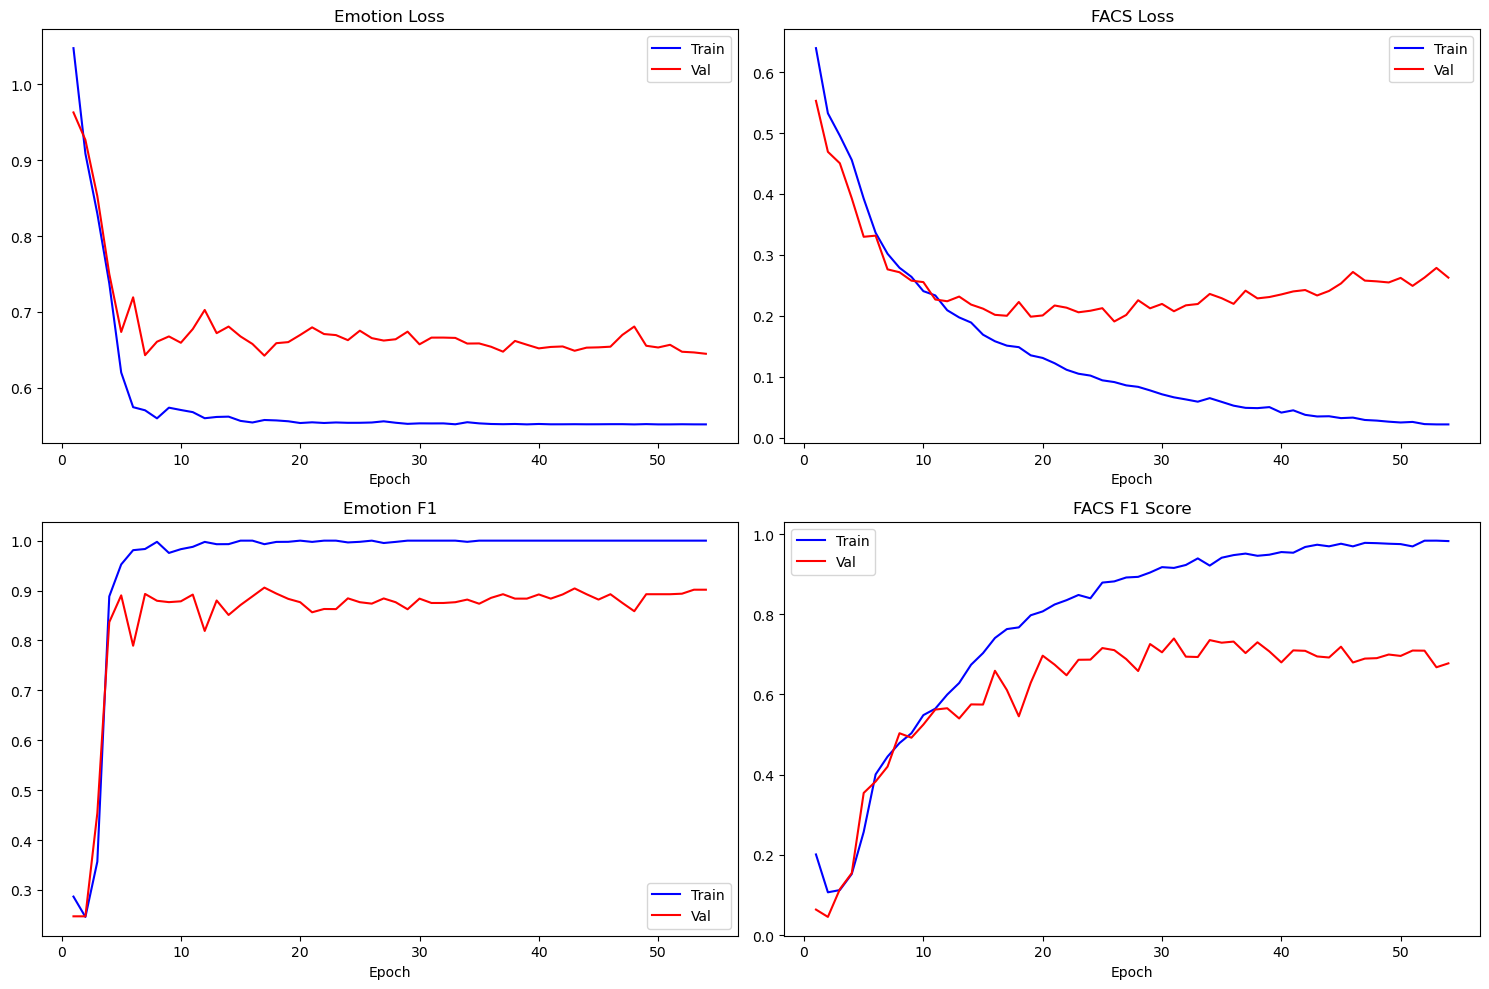

In [46]:
aug_resnet18_pretrained_trainer.plot_metrics()

## V. Evaluation
For models evaluation, refer to the notebook `evaluation_notebook.ipynb`

To validate more precisely, `val_df` is exported.

In [47]:
val_df.to_csv('data/validate_data.csv')